## Import libraries

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.pipeline import Pipeline
plt.style.use('default')  # Or 'classic', or your preferred style


import warnings
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import SelectFromModel
from scipy import stats
from scipy.stats import skew, kurtosis

from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import pickle

## Load data

In [19]:
# Input string to specify the dataset variant
input_variant = 'short'  # Change this depentend on your dataset

In [20]:
# Step 0. Load the Data
# df is result after feature selection and outlier elimination
df = pd.read_csv(f"df_ground_delay_prediction_data_{input_variant}.csv")

In [21]:
df.head()

change_reason_code_other problem  arr_ap_sched_East Carmen  \
0                              True                      True   
1                             False                      True   
2                              True                      True   
3                              True                      True   
4                              True                      True   

   change_reason_code_no reason  crew_type_change_[]  arr_time_of_day_Daytime  \
0                         False                 True                    False   
1                          True                 True                    False   
2                         False                 True                    False   
3                         False                 True                    False   
4                         False                 True                    False   

   crew_group_A  crew_group_A.1  crew_group_A.2  crew_group_A.3  \
0         False           False           False           False   
1         False           False           False           False   
2         False           False           False           False   
3         False           False           False           False   
4         False           False           False           False   

   sched_ground_time  ...  crew_group_C.1  crew_group_C.2  crew_group_C.3  \
0              235.0  ...           False           False           False   
1              130.0  ...           False           False           False   
2              185.0  ...           False           False           False   
3              145.0  ...           False           False           False   
4               35.0  ...           False           False           False   

   person_6_att3  change_reason_code_rotational problem  person_1_att1  \
0            NaN                                  False            NaN   
1            NaN                                  False            NaN   
2            NaN                                  False            NaN   
3            NaN                                  False            NaN   
4            NaN                                  False            NaN   

   arr_time_of_day_Evening Peak  dep_ap_sched_East Carmen  \
0                         False                     False   
1                         False                     False   
2                         False                     False   
3                         False                     False   
4                         False                     False   

   change_reason_code_technical problem  ground_time_delay  
0                                 False               33.0  
1                                 False               59.0  
2                                 False               11.0  
3                                 False               30.0  
4                                 False              -14.0  

[5 rows x 41 columns]

In [22]:
print("\nAnzahl fehlender Werte pro Spalte:")
print(df.isna().sum())



Anzahl fehlender Werte pro Spalte:
change_reason_code_other problem            0
arr_ap_sched_East Carmen                    0
change_reason_code_no reason                0
crew_type_change_[]                         0
arr_time_of_day_Daytime                     0
crew_group_A                                0
crew_group_A.1                              0
crew_group_A.2                              0
crew_group_A.3                              0
sched_ground_time                           0
arr_ap_sched_West Jason                     0
dep_time_of_day_Evening Peak                0
person_3_att3                            4279
person_4_att3                            4335
crew_group_B                                0
crew_group_B.1                              0
crew_group_B.2                              0
crew_group_B.3                              0
change_person_2_cp                          0
change_person_2_ca                          0
arr_ap_sched_West Bryanstad                 

In [23]:
# Remove specific rows with missing values
df_no_missing_columns = df.drop(columns=['person_7_att3', 'person_6_att2', 'person_6_att3', 'person_7_att2', 'person_5_att3', 'person_3_att3', 'person_4_att3', 'person_2_att3'])

# Überprüfen, ob die Spalten entfernt wurden
print(df_no_missing_columns.columns)

print("\nAnzahl fehlender Werte pro Spalte:")
print(df_no_missing_columns.isna().sum())

# # Remove all rows with missing values
df_no_missing_columns = df_no_missing_columns.dropna()

# Check if there are still missing values
print(df_no_missing_columns.isna().sum())
print(f"Number of remaining rows: {len(df_no_missing_columns)}")

df = df_no_missing_columns

Index(['change_reason_code_other problem', 'arr_ap_sched_East Carmen',
       'change_reason_code_no reason', 'crew_type_change_[]',
       'arr_time_of_day_Daytime', 'crew_group_A', 'crew_group_A.1',
       'crew_group_A.2', 'crew_group_A.3', 'sched_ground_time',
       'arr_ap_sched_West Jason', 'dep_time_of_day_Evening Peak',
       'crew_group_B', 'crew_group_B.1', 'crew_group_B.2', 'crew_group_B.3',
       'change_person_2_cp', 'change_person_2_ca',
       'arr_ap_sched_West Bryanstad', 'change_person_3_ca',
       'arr_ap_sched_Youngland', 'change_person_1_cp', 'pax_boarding_duration',
       'crew_group_C', 'crew_group_C.1', 'crew_group_C.2', 'crew_group_C.3',
       'change_reason_code_rotational problem', 'person_1_att1',
       'arr_time_of_day_Evening Peak', 'dep_ap_sched_East Carmen',
       'change_reason_code_technical problem', 'ground_time_delay'],
      dtype='object')

Anzahl fehlender Werte pro Spalte:
change_reason_code_other problem            0
arr_ap_sched_East C

In [ ]:
# # Remove all rows with missing values
# df_no_missing_columns = df.dropna()

# # Check if there are still missing values
# print(df_no_missing_columns.isna().sum())
# print(f"Number of remaining rows: {len(df_no_missing_columns)}")

# df = df_no_missing_columns

## 4. Model training and evaluation

### 4.2.2 Benchmark-model

Key Metrics for 'ground_time_delay':
- Mean: 3.89 minutes
- Median: 7.00 minutes
- Standard Deviation: 37.33
- Skewness: -0.63
- Kurtosis: 5.47


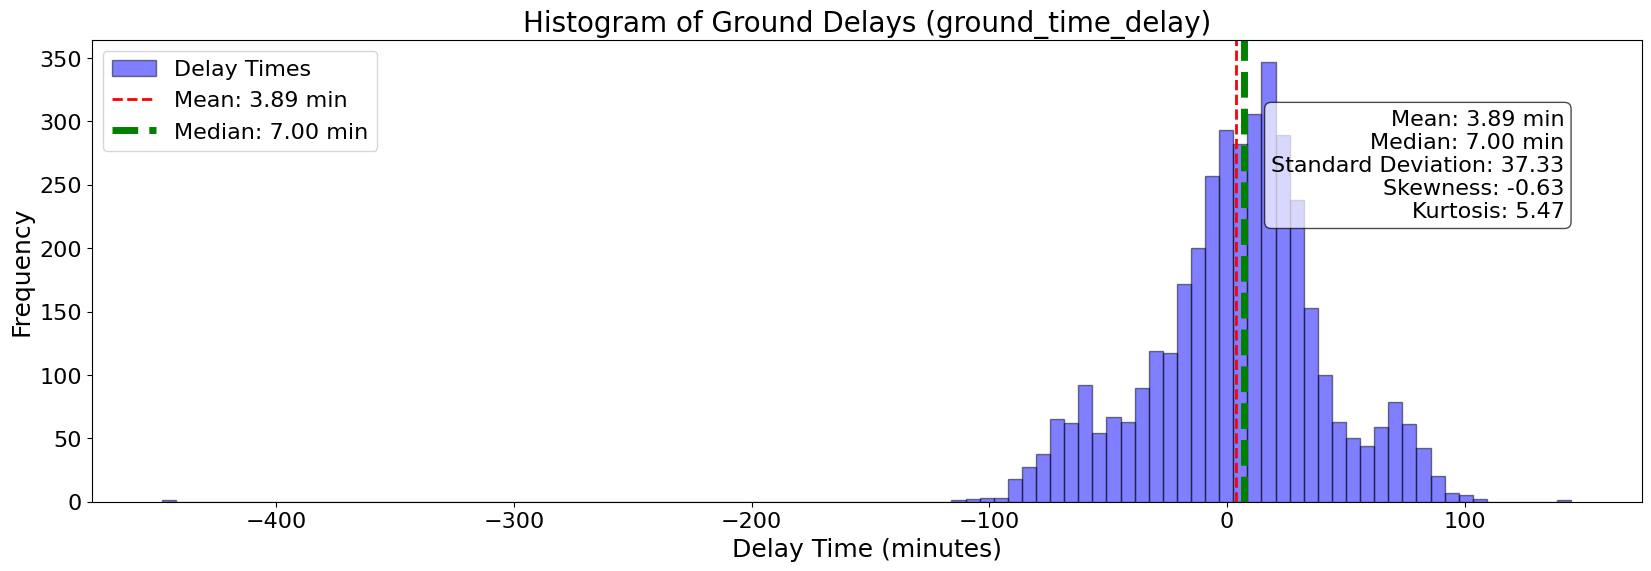

In [24]:
# Calculate key metrics for ground time delays
mean_delay = df['ground_time_delay'].mean()          # Mean value
median_delay = df['ground_time_delay'].median()      # Median value
std_delay = df['ground_time_delay'].std()            # Standard deviation
skewness = df['ground_time_delay'].skew()            # Skewness (asymmetry)
kurtosis = df['ground_time_delay'].kurtosis()        # Kurtosis (tailedness)

# Print important metrics to the console
print("Key Metrics for 'ground_time_delay':")
print(f"- Mean: {mean_delay:.2f} minutes")
print(f"- Median: {median_delay:.2f} minutes")
print(f"- Standard Deviation: {std_delay:.2f}")
print(f"- Skewness: {skewness:.2f}")
print(f"- Kurtosis: {kurtosis:.2f}")

# Create a histogram of 'ground_time_delay'
plt.figure(figsize=(20, 6))

# Plot the histogram of the ground_time_delay
plt.hist(df['ground_time_delay'], bins=100, color='blue', alpha=0.5, label='Delay Times', edgecolor='black')

# Add vertical lines for mean and median
plt.axvline(mean_delay, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_delay:.2f} min')
plt.axvline(median_delay, color='green', linestyle='dashed', linewidth=5, label=f'Median: {median_delay:.2f} min')

# Add title and labels for the axes
plt.title('Histogram of Ground Delays (ground_time_delay)', fontsize=20)  # Larger title font size
plt.xlabel('Delay Time (minutes)', fontsize=18)  # Larger x-axis label font size
plt.ylabel('Frequency', fontsize=18)  # Larger y-axis label font size

# Add text box with key metrics in the plot
textstr = (f'Mean: {mean_delay:.2f} min\n'
           f'Median: {median_delay:.2f} min\n'
           f'Standard Deviation: {std_delay:.2f}\n'
           f'Skewness: {skewness:.2f}\n'
           f'Kurtosis: {kurtosis:.2f}')
plt.text(0.95, 0.85, textstr, transform=plt.gca().transAxes, fontsize=16,
         verticalalignment='top', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))

# Add a legend to the plot
plt.legend(loc='upper left', fontsize=16)  # Increase legend font size

# Adjust the font size of tick labels
plt.tick_params(axis='both', which='major', labelsize=16)  # Increase tick label font size

# Display the histogram
plt.show()

### 4.1 Data preparation

In [25]:
class DataPreparation:
    """
    A class for preparing data for machine learning models. This includes 
    splitting data into training and testing sets, applying scaling and 
    normalization, and handling model-specific preprocessing.

    Attributes:
        df (pd.DataFrame): The input DataFrame.
        target_column (str): The name of the target column for prediction.
        test_size (float): Proportion of the dataset to include in the test split.
        random_state (int): Random seed for reproducibility.
    """

    def __init__(self, df, target_column, test_size=0.2, random_state=42):
        """
        Initializes the DataPreparation class and splits the data into train and test sets.

        Args:
            df (pd.DataFrame): The input DataFrame.
            target_column (str): The name of the target column.
            test_size (float): Proportion of the data to use for testing.
            random_state (int): Random state for reproducibility.
        """
        self.df = df
        self.target_column = target_column
        self.test_size = test_size
        self.random_state = random_state
        self.X_train, self.X_test, self.y_train, self.y_test = self._split_data()

    def _split_data(self):
        """Splits the data into training and testing sets."""
        X = self.df.drop(columns=[self.target_column])  # Features
        y = self.df[self.target_column]  # Target variable

        # Split data into train and test
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state
        )

        # Convert targets to DataFrames to retain column names
        y_train = y_train.to_frame()
        y_test = y_test.to_frame()

        return X_train, X_test, y_train, y_test

    def apply_scaling(self, scaling_method="standard"):
        """
        Scales the data using the specified method.

        Args:
            scaling_method (str): The scaling method to use ('standard' or 'minmax').

        Returns:
            tuple: Scaled training and testing features as DataFrames.
        """
        if scaling_method == "standard":
            scaler = StandardScaler()
        elif scaling_method == "minmax":
            scaler = MinMaxScaler()
        else:
            raise ValueError("Unknown scaling method. Use 'standard' or 'minmax'.")

        self.scaler = scaler  # Save scaler for reuse
        self.X_train = pd.DataFrame(scaler.fit_transform(self.X_train), columns=self.X_train.columns)
        self.X_test = pd.DataFrame(scaler.transform(self.X_test), columns=self.X_test.columns)
        print(f"Applied {scaling_method} scaling to the data.")
        return self.X_train, self.X_test

    def apply_normalization(self, norm_method="l2"):
        """
        Normalizes the data using the specified method.

        Args:
            norm_method (str): The normalization method ('l2' or 'l1').

        Returns:
            tuple: Normalized training and testing features as DataFrames.
        """
        normalizer = Normalizer(norm=norm_method)
        self.normalizer = normalizer  # Save normalizer for reuse
        self.X_train = pd.DataFrame(normalizer.fit_transform(self.X_train), columns=self.X_train.columns)
        self.X_test = pd.DataFrame(normalizer.transform(self.X_test), columns=self.X_test.columns)
        print(f"Applied {norm_method} normalization to the data.")
        return self.X_train, self.X_test

    def preprocess_for_model(self, model_name):
        """
        Applies model-specific preprocessing based on the model type.

        Args:
            model_name (str): The name of the model to preprocess for.

        Returns:
            tuple: Preprocessed training and testing features as DataFrames.
        """
        if model_name in ["BenchmarkModel", "RandomForest", "DecisionTree", "GradientBoosting", "XGBoost", "LightGBM", "HistGradientBoosting"]:
            print(f"No scaling or normalization required for {model_name}.")
        elif model_name in ["LinearRegression", "RidgeRegression", "LassoRegression", "MLP", "ElasticNet", "PolynomialRegression"]:
            self.apply_scaling("standard")
        elif model_name == "KNN":
            self.apply_scaling("minmax")
            self.apply_normalization("l2")
        elif model_name in ["SVM", "SVR"]:
            self.apply_scaling("standard")
            self.apply_normalization("l2")
        elif model_name == "LogisticRegression":
            self.apply_scaling("standard")
        else:
            raise ValueError(f"Unknown model name: {model_name}. Define preprocessing rules.")

        print(f"Completed preprocessing for {model_name}.")
        return self.X_train, self.X_test

### 4.2 Model training

In [26]:
class ModelTraining:
    """
    A class for training and tuning machine learning models with hyperparameter optimization.
    
    Attributes:
        data_preparation (DataPreparation): An instance of the DataPreparation class.
        best_models (dict): A dictionary storing the best models for each algorithm.
        model_dict (dict): A dictionary containing model objects and hyperparameters.
        results_table (list): A list of results for evaluation metrics.
    """

    def __init__(self, data_preparation):
        """
        Initializes the ModelTraining class.
        
        Args:
            data_preparation (DataPreparation): An instance of the DataPreparation class.
        """
        self.data_preparation = data_preparation
        self.best_models = {}
        self.model_dict = {}
        self.results_table = []

    def add_model(self, model_name, model, params):
        """
        Adds a model and its hyperparameters to the training pipeline.

        Args:
            model_name (str): Name of the model.
            model: The machine learning model object.
            params (dict): Dictionary of hyperparameters for the model.
        """
        self.model_dict[model_name] = {'model': model, 'param_grid': params}
        print(f"Model {model_name} added with params: {params}")

    def train_and_tune_models(self, evaluator):
        """
        Trains and tunes all added models using cross-validation and stores the results.

        Args:
            evaluator: An instance of the ModelEvaluation class for calculating evaluation metrics.
        """
        for model_name, model_info in self.model_dict.items():
            print(f"Training {model_name}...")

            # Preprocess data based on model requirements
            X_train, X_test = self.data_preparation.preprocess_for_model(model_name)
            y_train, y_test = self.data_preparation.y_train.copy(), self.data_preparation.y_test.copy()

            y_train = y_train.squeeze()  # Ensure y_train is a Series

            model = model_info['model']
            param_grid = model_info['param_grid']

            # Perform grid search for hyperparameter tuning
            grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
            grid_search.fit(X_train, y_train)

            # Save the best model
            self.best_models[model_name] = grid_search.best_estimator_
            print(f"Best hyperparameters for {model_name}: {grid_search.best_params_}")
            print(f"Best cross-validation score for {model_name}: {grid_search.best_score_}")

            # Evaluate each hyperparameter combination
            for i in range(len(grid_search.cv_results_['params'])):
                params = grid_search.cv_results_['params'][i]
                params_str = str(params)
                mean_test_score = -grid_search.cv_results_['mean_test_score'][i]
                rmse = np.sqrt(mean_test_score)

                # Predict training data
                y_pred_train = grid_search.predict(X_train)
                y_pred_train = np.array(y_pred_train).flatten()

                # Calculate metrics
                mae = mean_absolute_error(y_train, y_pred_train)
                r2 = r2_score(y_train, y_pred_train)

                # Calculate residuals and metrics
                residuals = y_train - y_pred_train
                residuals = residuals[~np.isnan(residuals) & ~np.isinf(residuals)]
                residual_metrics = evaluator.calculate_residual_metrics(residuals)

                # Append results
                self.results_table.append({
                    'Model': model_name,
                    'Hyperparameters': params_str,
                    'MSE': mean_test_score,
                    'RMSE': rmse,
                    'MAE': mae,
                    'R²': r2,
                    'Residual Mean': residual_metrics['residual_mean'],
                    'Skewness': residual_metrics['skewness'],
                    'Kurtosis': residual_metrics['kurtosis'],
                })

            # Plot hyperparameter effects
            self.plot_hyperparameter_vs_score(grid_search, model_name)

    def train_and_tune_single_model(self, model_name, evaluator):
        """
        Trains and tunes a specific model by its name.

        Args:
            model_name (str): Name of the model to train.
            evaluator: An instance of the ModelEvaluation class for calculating evaluation metrics.
        """
        if model_name not in self.model_dict:
            print(f"{model_name} not found!")
            return

        # Preprocess data
        X_train, X_test = self.data_preparation.preprocess_for_model(model_name)
        y_train, y_test = self.data_preparation.y_train.copy(), self.data_preparation.y_test.copy()

        y_train = y_train.squeeze()

        model_info = self.model_dict[model_name]
        print(f"Training {model_name}...")

        model = model_info['model']
        param_grid = model_info['param_grid']

        # Perform grid search
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)

        # Save the best model
        self.best_models[model_name] = grid_search.best_estimator_
        print(f"Best hyperparameters for {model_name}: {grid_search.best_params_}")
        print(f"Best cross-validation score for {model_name}: {grid_search.best_score_}")

        # Evaluate and store results
        for i in range(len(grid_search.cv_results_['params'])):
            params = grid_search.cv_results_['params'][i]
            params_str = str(params)
            mean_test_score = -grid_search.cv_results_['mean_test_score'][i]
            rmse = np.sqrt(mean_test_score)

            y_pred_train = grid_search.predict(X_train).flatten()
            mae = mean_absolute_error(y_train, y_pred_train)
            r2 = r2_score(y_train, y_pred_train)

            residuals = y_train - y_pred_train
            residuals = residuals[~np.isnan(residuals) & ~np.isinf(residuals)]
            residual_metrics = evaluator.calculate_residual_metrics(residuals)

            self.results_table.append({
                'Model': model_name,
                'Hyperparameters': params_str,
                'MSE': mean_test_score,
                'RMSE': rmse,
                'MAE': mae,
                'R²': r2,
                'Residual Mean': residual_metrics['residual_mean'],
                'Skewness': residual_metrics['skewness'],
                'Kurtosis': residual_metrics['kurtosis'],
            })

        self.plot_hyperparameter_vs_score(grid_search, model_name)

    def plot_hyperparameter_vs_score(self, grid_search, model_name="Model"):
        """
        Plots the effect of hyperparameters on model performance.

        Args:
            grid_search: A fitted GridSearchCV object.
            model_name (str): The name of the model.
        """
        results_df = pd.DataFrame(grid_search.cv_results_)
        param_columns = [col for col in results_df.columns if col.startswith('param_')]

        title_fontsize = 18
        label_fontsize = 14
        tick_fontsize = 12
        legend_fontsize = 12

        for param in param_columns:
            plt.figure(figsize=(10, 6))

            for value in results_df[param].unique():
                # Filter results for the current parameter value
                filtered_results = results_df[results_df[param] == value].copy()
                other_params = [col for col in param_columns if col != param]

                if other_params:
                    other_param = other_params[0]  # Get the secondary parameter
                    other_param_values = pd.to_numeric(filtered_results[other_param], errors='coerce')
                    mean_test_scores = pd.to_numeric(filtered_results['mean_test_score'], errors='coerce')

                    # Plot with corrected x-axis label
                    plt.plot(
                        other_param_values,
                        mean_test_scores,
                        marker='o',
                        label=f'{param} = {value}'
                    )
                    plt.xlabel(other_param, fontsize=label_fontsize)  # Use `other_param` for x-axis label
                else:
                    # When there's only one parameter
                    param_values = pd.to_numeric(filtered_results[param], errors='coerce')
                    mean_test_scores = pd.to_numeric(filtered_results['mean_test_score'], errors='coerce')

                    plt.plot(
                        param_values,
                        mean_test_scores,
                        marker='o',
                        label=f'{param}'
                    )
                    plt.xlabel(param, fontsize=label_fontsize)  # Use `param` for x-axis label

            plt.ylabel('Mean Test Score (MSE)', fontsize=label_fontsize)
            plt.title(f'{model_name}: Hyperparameter Effect', fontsize=title_fontsize)
            plt.xticks(fontsize=tick_fontsize)
            plt.yticks(fontsize=tick_fontsize)
            plt.legend(fontsize=legend_fontsize)
            plt.grid()
            plt.show()


    def update_data_preparation(self, new_data_preparation):
        """
        Updates the data preparation instance without retraining models.

        Args:
            new_data_preparation (DataPreparation): A new instance of DataPreparation.
        """
        self.data_preparation = new_data_preparation
        print("DataPreparation instance updated.")

### 4.3 Model evaluation

In [27]:
class ModelEvaluation:
    """
    A class for evaluating trained machine learning models on test data and analyzing residuals.

    Attributes:
        data_preparation (DataPreparation): An instance of the DataPreparation class.
        best_models (dict): A dictionary of the best models from training.
        evaluation_results (list): A list to store evaluation results, residuals, and metrics.
    """

    def __init__(self, data_preparation, best_models):
        """
        Initializes the ModelEvaluation class.

        Args:
            data_preparation (DataPreparation): An instance of the DataPreparation class.
            best_models (dict): Dictionary containing the trained models from ModelTraining.
        """
        self.data_preparation = data_preparation
        self.best_models = best_models
        self.evaluation_results = []

    def evaluate_model(self, model_name):
        """
        Evaluates the specified model using test data and calculates residual and performance metrics.

        Args:
            model_name (str): The name of the model to evaluate.
        """
        # Get preprocessed test data
        X_train, X_test = self.data_preparation.preprocess_for_model(model_name)
        y_test = self.data_preparation.y_test.copy()

        # Retrieve the trained model
        model = self.best_models.get(model_name)
        if model is None:
            raise ValueError(f"Model '{model_name}' not found in best_models.")

        # Predict on test data
        y_pred = model.predict(X_test)

        # Validate predictions and test data
        valid_mask = ~np.isnan(y_pred) & ~np.isinf(y_pred)
        y_pred = y_pred[valid_mask]
        y_test = y_test[valid_mask]

        if len(y_test) != len(y_pred):
            raise ValueError(f"Length mismatch: y_test has {len(y_test)} elements, but y_pred has {len(y_pred)} elements.")

        y_test = np.ravel(y_test)
        y_pred = np.ravel(y_pred)

        # Calculate residuals
        residuals = y_test - y_pred
        residuals = residuals[~np.isnan(residuals) & ~np.isinf(residuals)]

        # Compute residual and error metrics
        residuals_metrics = self.calculate_residual_metrics(residuals)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        # Print evaluation metrics
        print(f"Evaluating model: {model_name}")
        print(f"Mean Absolute Error (MAE): {mae:.2f}")
        print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
        print(f"R² Score (R²): {r2:.2f}")
        print(f"Residual Mean: {residuals_metrics['residual_mean']:.4f}")
        print(f"Skewness: {residuals_metrics['skewness']:.4f}")
        print(f"Kurtosis: {residuals_metrics['kurtosis']:.4f}")

        # Save or update evaluation results
        metrics = {
            'MAE': mae,
            'RMSE': rmse,
            'R²': r2,
            **residuals_metrics
        }
        existing_entry = next((entry for entry in self.evaluation_results if entry['model_name'] == model_name), None)
        if existing_entry:
            existing_entry.update({'metrics': metrics, 'residuals': residuals, 'predictions': y_pred})
        else:
            self.evaluation_results.append({
                'model_name': model_name,
                'metrics': metrics,
                'residuals': residuals,
                'predictions': y_pred
            })

    def calculate_residual_metrics(self, residuals):
        """
        Calculates key metrics for residual analysis.

        Args:
            residuals (array-like): Residuals from model predictions.

        Returns:
            dict: A dictionary containing residual mean, skewness, and kurtosis.
        """
        residuals_series = pd.Series(residuals)
        return {
            'residual_mean': residuals_series.mean(),
            'skewness': residuals_series.skew(),
            'kurtosis': residuals_series.kurtosis()
        }

    def plot_residual_diagnostics(self, residuals, y_pred, model_name):
        """
        Generates residual diagnostics plots for the specified model.

        Args:
            residuals (array-like): Residuals from model predictions.
            y_pred (array-like): Predicted values from the model.
            model_name (str): The name of the model for the plot title.
        """
        # Residuals vs Predicted Plot
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=y_pred, y=residuals)
        plt.axhline(0, color='red', linestyle='--')
        plt.title(f'Residuals vs Predicted for {model_name}')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.grid(True)
        plt.show()

        # Residual Histogram
        plt.figure(figsize=(6, 4))
        sns.histplot(residuals, kde=True, color='purple', bins=30)
        plt.title(f'Residuals Histogram for {model_name}')
        plt.xlabel('Residuals')
        plt.ylabel('Frequency')
        plt.show()

    def update_data_preparation(self, new_data_preparation):
        """
        Updates the data preparation instance without retraining models.

        Args:
            new_data_preparation (DataPreparation): A new DataPreparation instance.
        """
        self.data_preparation = new_data_preparation
        print("DataPreparation instance updated in ModelEvaluation.")

### Model Training and Evaluation

In [28]:
# 1. Initialize DataPreparation class
data_prep_ground_delay = DataPreparation(df, target_column="ground_time_delay")

In [ ]:
# # Only necessary when something changes in data_preparation and you don't want to loose instances of trainer and evaluator
# # Use following code to update instances of ModelTraining and ModelEvaluation without overwriting it
# data_prep_ground_delay = DataPreparation(df, target_column="ground_time_delay")
# model_trainer_ground_delay.update_data_preparation(data_prep_ground_delay)
# model_evaluator_ground_delay.update_data_preparation(data_prep_ground_delay)

In [29]:
# Step 2: Instantiate ModelTraining with only the data preparation
model_trainer_ground_delay = ModelTraining(data_prep_ground_delay)

In [30]:
# Step 3: Instantiate ModelEvaluation with only the data preparation and best_model
model_evaluator_ground_delay = ModelEvaluation(data_prep_ground_delay, model_trainer_ground_delay.best_models)

In [32]:
#Step 4: Adding and Configuring Models
"""
This script demonstrates adding multiple machine learning models with hyperparameter grids
to the ModelTraining instance for automated training and tuning.
"""

# Benchmark Model (Median) ----------------------------------------------------------------------------
from sklearn.dummy import DummyRegressor

# Create a baseline model using the median as the prediction
Benchmark_model = DummyRegressor(strategy="median")
# The benchmark model does not have hyperparameters
Benchmark_params = {}
model_trainer_ground_delay.add_model('BenchmarkModel', Benchmark_model, Benchmark_params)

# Forest-Based Algorithms ---------------------------------------------------------------------------
from sklearn.ensemble import RandomForestRegressor

# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [10, 100, 250, 500, 750, 1000],  # Number of trees in the forest
    'max_depth': [1, 5, 8, 10, 12, 15, 20]  # Maximum depth of the trees
}
model_trainer_ground_delay.add_model('RandomForest', rf_model, rf_params)

# Linear Regression Algorithms ----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression

# Simple Linear Regression (default parameters, no hyperparameter tuning)
lr_model = LinearRegression()
lr_params = {}
model_trainer_ground_delay.add_model('LinearRegression', lr_model, lr_params)

from sklearn.linear_model import Ridge

# Ridge Regression (L2 regularization)
ridge_model = Ridge(random_state=42)
ridge_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
model_trainer_ground_delay.add_model('RidgeRegression', ridge_model, ridge_params)

from sklearn.linear_model import Lasso

# Lasso Regression (L1 regularization)
lasso_model = Lasso(random_state=42)
lasso_params = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
model_trainer_ground_delay.add_model('LassoRegression', lasso_model, lasso_params)

from sklearn.linear_model import ElasticNet

# ElasticNet (combines L1 and L2 regularization)
en_model = ElasticNet(random_state=42)
en_params = {'alpha': [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1], 'l1_ratio': [0, 0.1, 0.5, 0.9, 0.95, 0.99]}
model_trainer_ground_delay.add_model('ElasticNet', en_model, en_params)

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

# Polynomial Regression with Ridge Regularization
poly_model = Pipeline([
    ('poly_features', PolynomialFeatures(include_bias=False)),
    ('ridge_regression', Ridge(random_state=42))
])
poly_params = {
    'poly_features__degree': [1, 2, 3, 4],  # Polynomial degree
    'ridge_regression__alpha': [0, 0.01, 0.1, 1, 10, 100, 1000]  # Ridge regularization strength
}
model_trainer_ground_delay.add_model('PolynomialRegression', poly_model, poly_params)

# Support Vector Regression (SVR) -------------------------------------------------------------------
from sklearn.svm import SVR

# SVR with multiple kernels and hyperparameter options
svr_model = SVR()
svr_params = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'epsilon': [0.01, 0.1, 0.2, 0.5],  # Epsilon-insensitive loss
    'kernel': ['linear', 'poly', 'rbf'],  # Kernel types
    'degree': [2, 3, 4]  # Polynomial kernel degree
}
model_trainer_ground_delay.add_model('SVR', svr_model, svr_params)

# Boosting Algorithms -------------------------------------------------------------------------------
from sklearn.ensemble import GradientBoostingRegressor

# Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)
gb_params = {
    'n_estimators': [50, 100, 200, 500],  # Number of boosting stages
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Shrinkage rate
    'max_depth': [3, 5, 8, 10],  # Maximum depth of individual trees
    'subsample': [0.7, 0.8, 0.9, 1.0]  # Fraction of samples used for fitting
}
model_trainer_ground_delay.add_model('GradientBoosting', gb_model, gb_params)

# HistGradientBoostingRegressor -------------------------------------------------------------------
from sklearn.ensemble import HistGradientBoostingRegressor

# HistGradientBoostingRegressor with hyperparameter options
hgb_model = HistGradientBoostingRegressor(random_state=42)
hgb_params = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Learning rate for gradient boosting
    'max_depth': [3, 5, 7, None],  # Maximum depth of each tree
    'max_iter': [100, 200, 300],  # Number of boosting iterations
    'l2_regularization': [0.0, 0.1, 1.0],  # L2 regularization strength
    'max_leaf_nodes': [10, 25, 50, 100],  # Maximum number of leaf nodes
    'min_samples_leaf': [20, 50, 100]  # Minimum number of samples per leaf
}
model_trainer_ground_delay.add_model('HistGradientBoosting', hgb_model, hgb_params)

# Deep Learning - MLP Regressor ----------------------------------------------------------------------
from sklearn.neural_network import MLPRegressor

# Multilayer Perceptron Regressor
mlp_model = MLPRegressor(random_state=42)
mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],  # Single-layer and multi-layer architectures
    'activation': ['relu', 'tanh'],  # Activation functions
    'solver': ['adam'],  # Optimizer
    'learning_rate': ['constant', 'adaptive'],  # Learning rate schedules
    'learning_rate_init': [0.001, 0.01],  # Initial learning rates
    'max_iter': [200, 500, 1000, 5000],  # Maximum iterations
    'tol': [1e-4, 1e-5],  # Tolerance for convergence
    'batch_size': ['auto', 32]  # Batch size
}
model_trainer_ground_delay.add_model('MLP', mlp_model, mlp_params)

Model BenchmarkModel added with params: {}
Model RandomForest added with params: {'n_estimators': [10, 100, 250, 500, 750, 1000], 'max_depth': [1, 5, 8, 10, 12, 15, 20]}
Model LinearRegression added with params: {}
Model RidgeRegression added with params: {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
Model LassoRegression added with params: {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
Model ElasticNet added with params: {'alpha': [0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1], 'l1_ratio': [0, 0.1, 0.5, 0.9, 0.95, 0.99]}
Model PolynomialRegression added with params: {'poly_features__degree': [1, 2, 3, 4], 'ridge_regression__alpha': [0, 0.01, 0.1, 1, 10, 100, 1000]}
Model SVR added with params: {'C': [0.1, 1, 10, 100], 'epsilon': [0.01, 0.1, 0.2, 0.5], 'kernel': ['linear', 'poly', 'rbf'], 'degree': [2, 3, 4]}
Model GradientBoosting added with params: {'n_estimators': [50, 100, 200, 500], 'learning_rate': [0.01, 0.05, 0.1, 0.2], 'max_depth': [3, 5, 8, 10], 'subsample': [0.7, 0.8, 0.9, 1.0]}


Applied standard scaling to the data.
Applied l2 normalization to the data.
Completed preprocessing for SVR.
Training SVR...
Best hyperparameters for SVR: {'C': 100, 'degree': 2, 'epsilon': 0.01, 'kernel': 'rbf'}
Best cross-validation score for SVR: -668.5997034185086


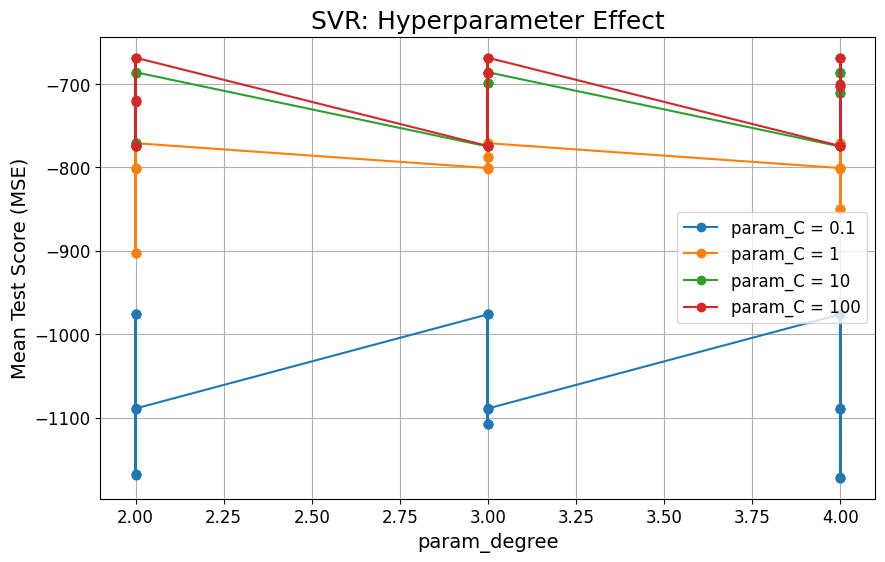

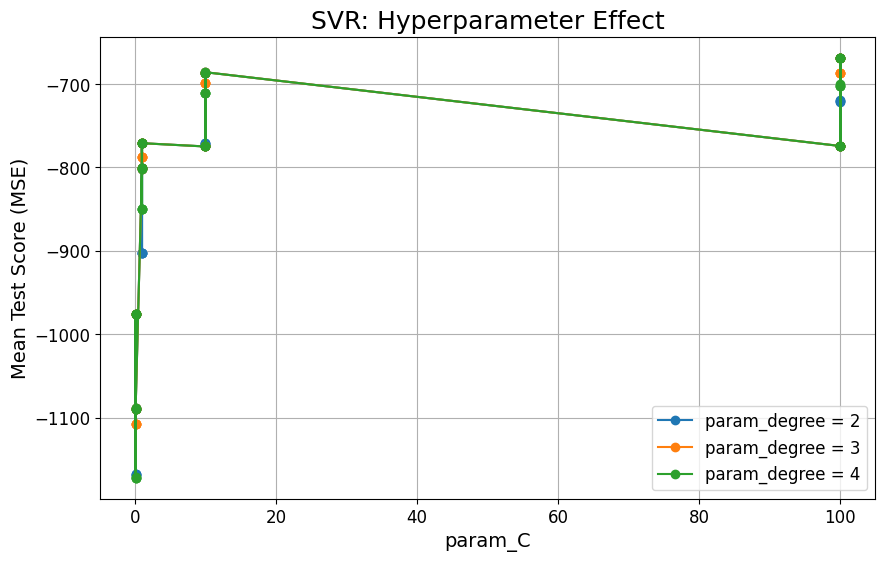

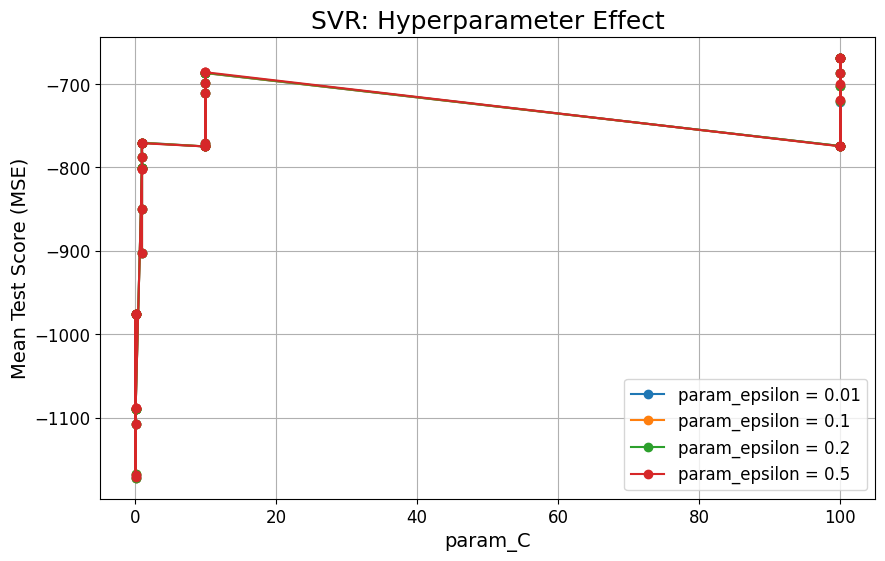

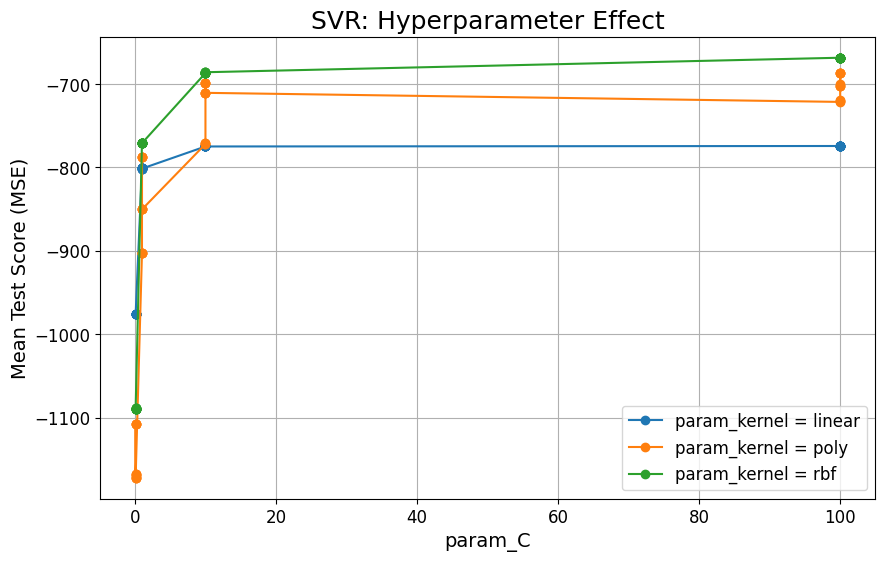

No scaling or normalization required for GradientBoosting.
Completed preprocessing for GradientBoosting.
Training GradientBoosting...
Best hyperparameters for GradientBoosting: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.9}
Best cross-validation score for GradientBoosting: -634.6669571229343


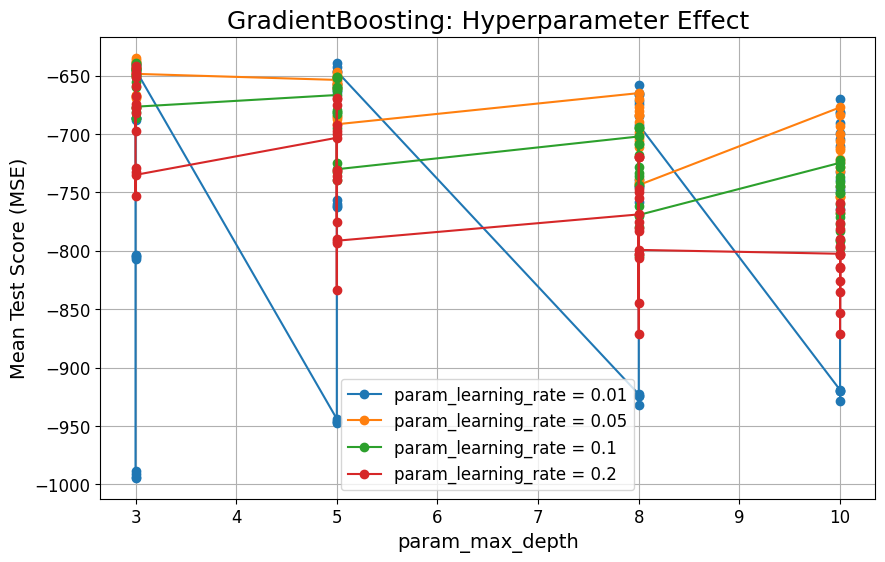

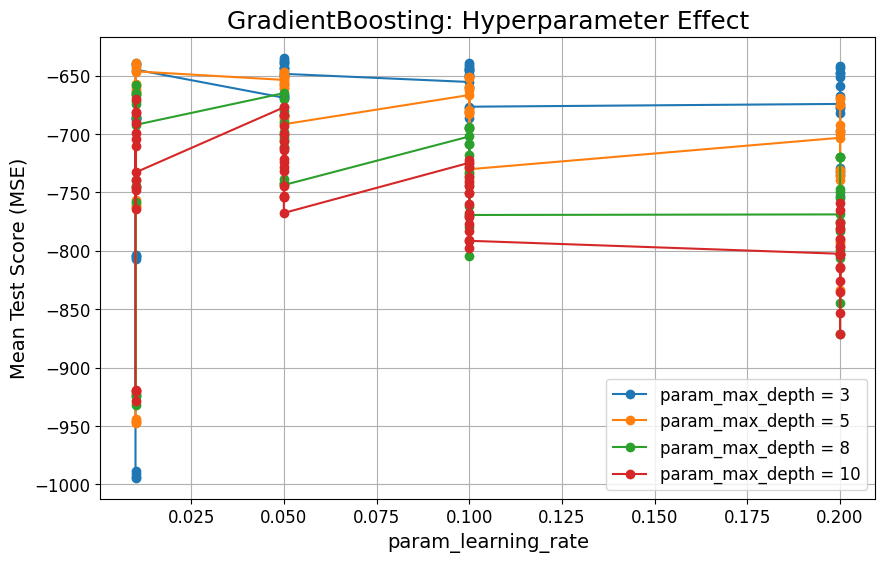

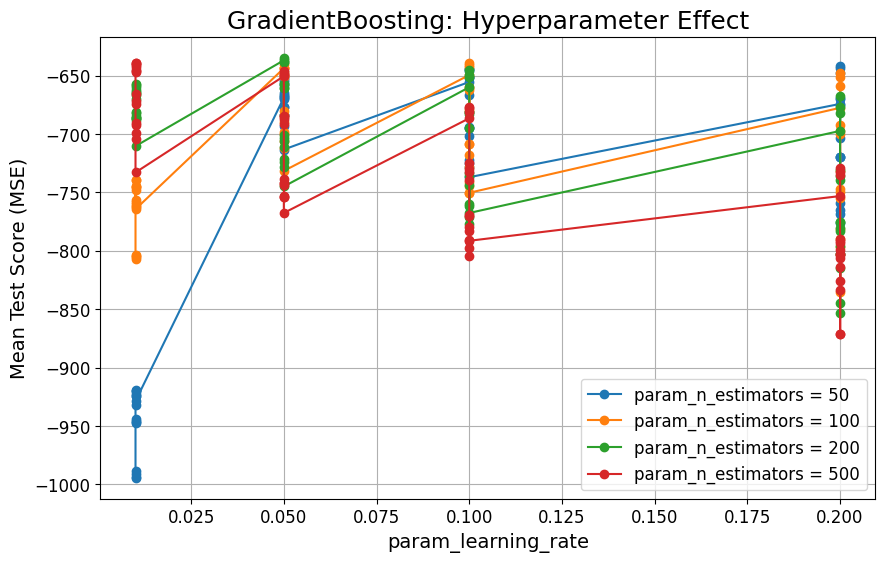

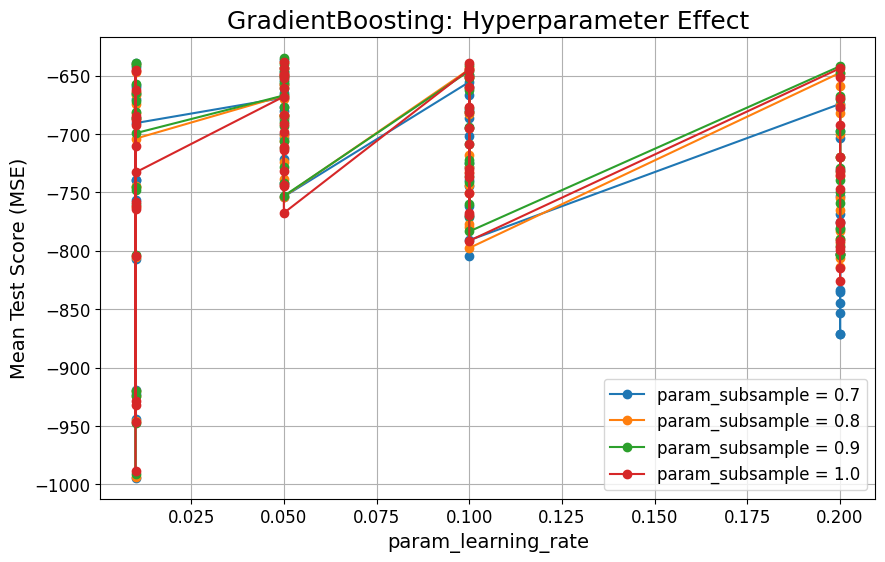

No scaling or normalization required for HistGradientBoosting.
Completed preprocessing for HistGradientBoosting.
Training HistGradientBoosting...
Best hyperparameters for HistGradientBoosting: {'l2_regularization': 0.1, 'learning_rate': 0.05, 'max_depth': 7, 'max_iter': 100, 'max_leaf_nodes': 10, 'min_samples_leaf': 20}
Best cross-validation score for HistGradientBoosting: -632.8197537060322


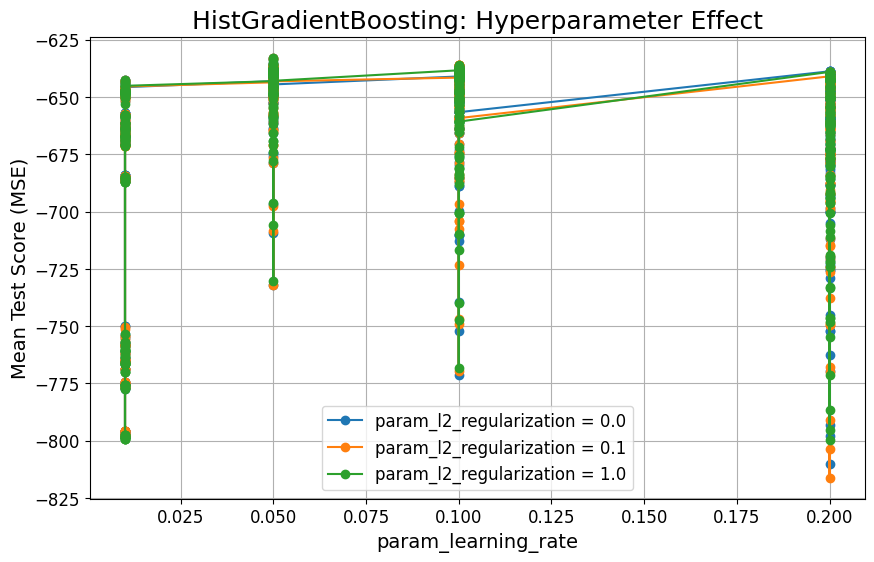

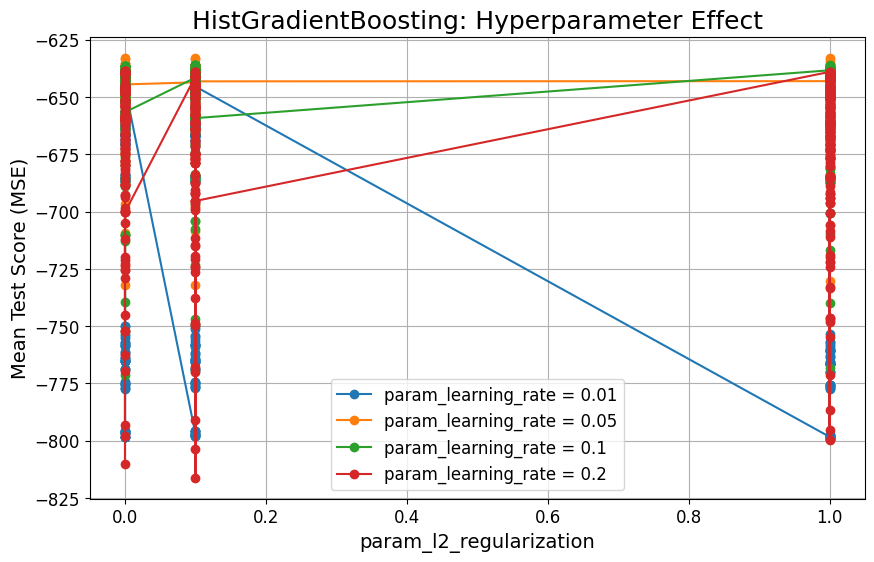

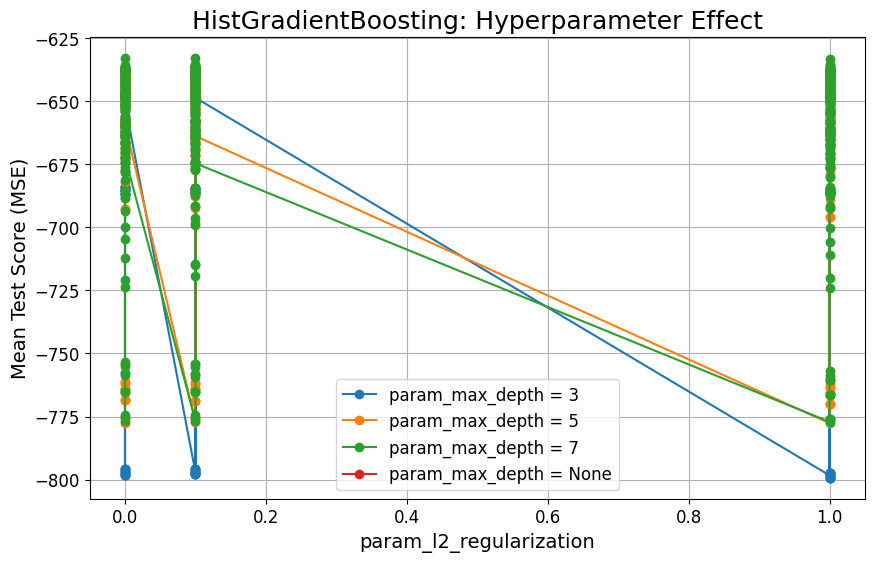

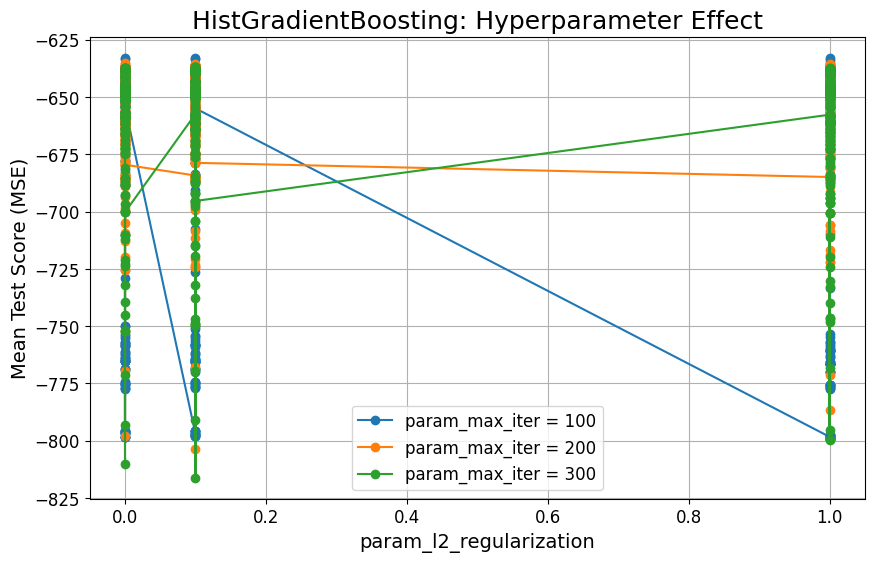

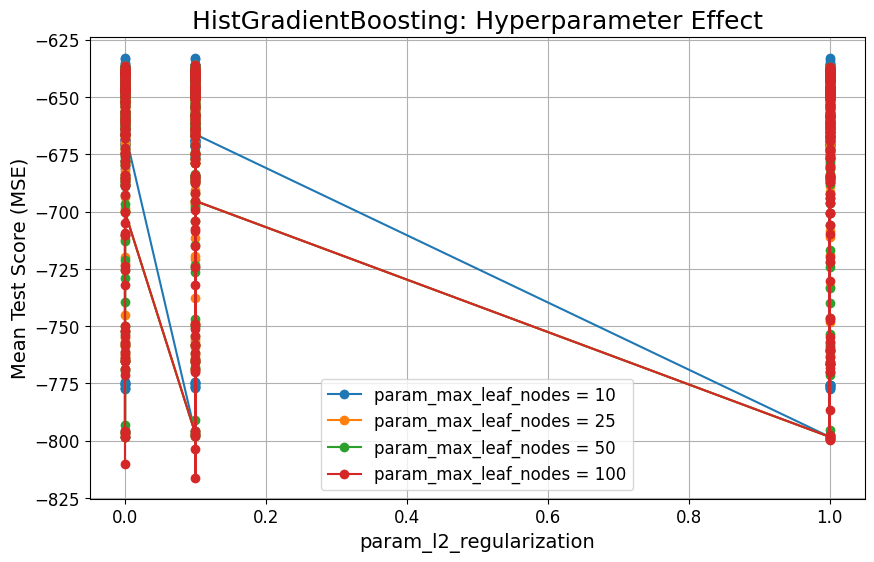

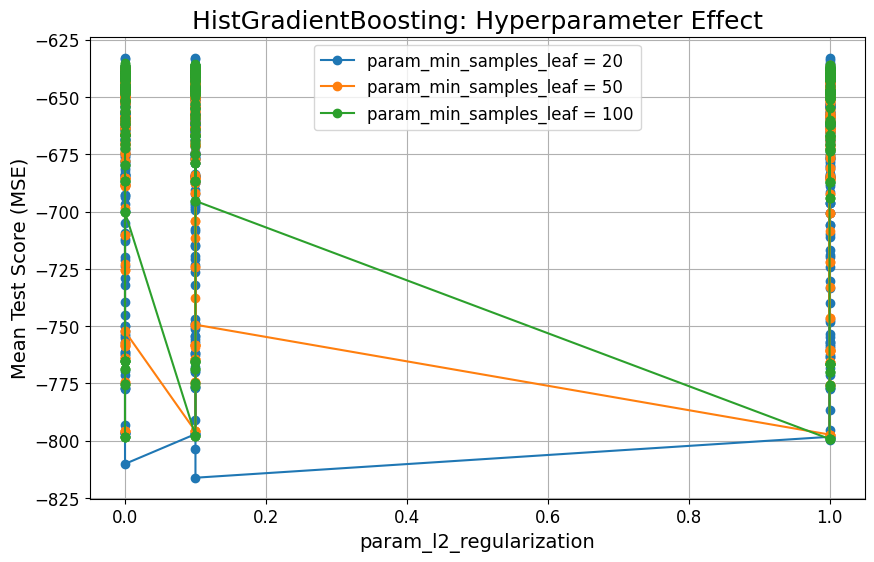

Applied standard scaling to the data.
Completed preprocessing for MLP.
Training MLP...


c:\Users\marti\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best hyperparameters for MLP: {'activation': 'tanh', 'batch_size': 32, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam', 'tol': 0.0001}
Best cross-validation score for MLP: -636.477174023192


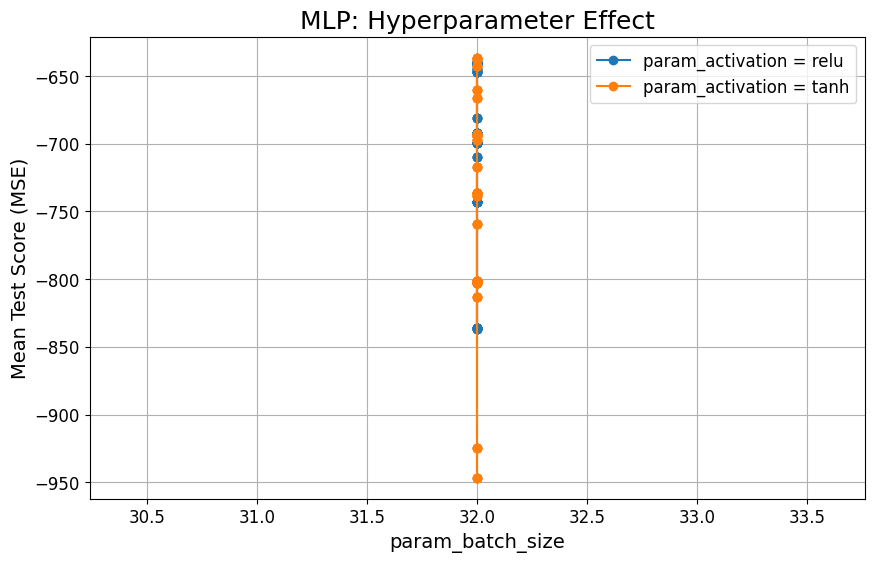

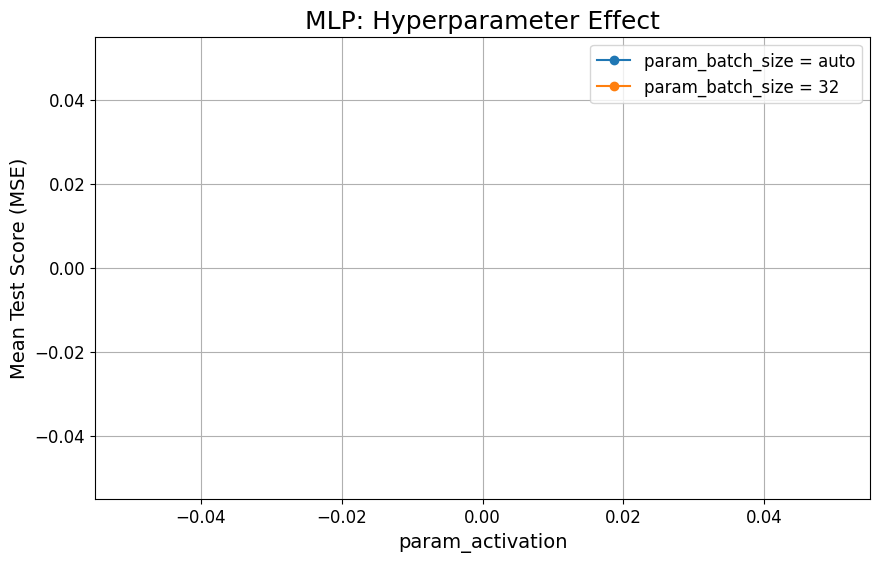

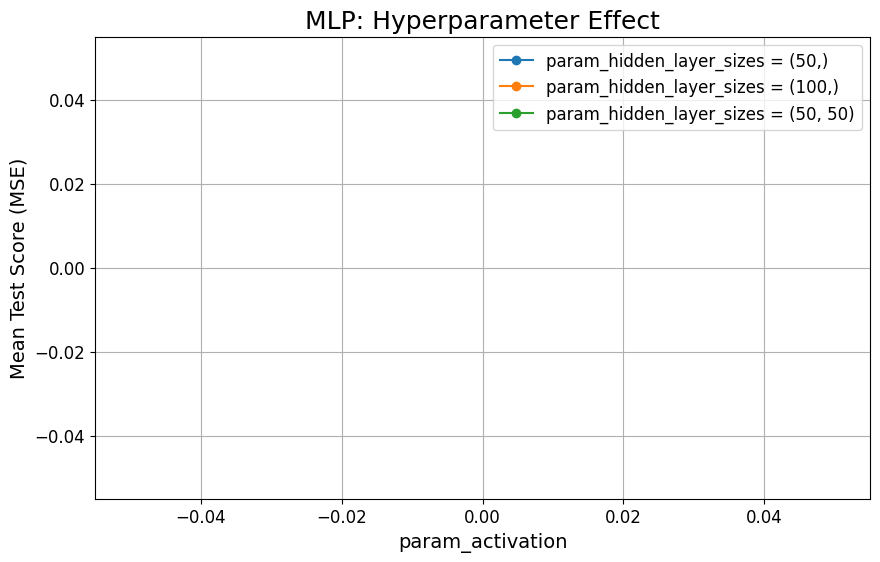

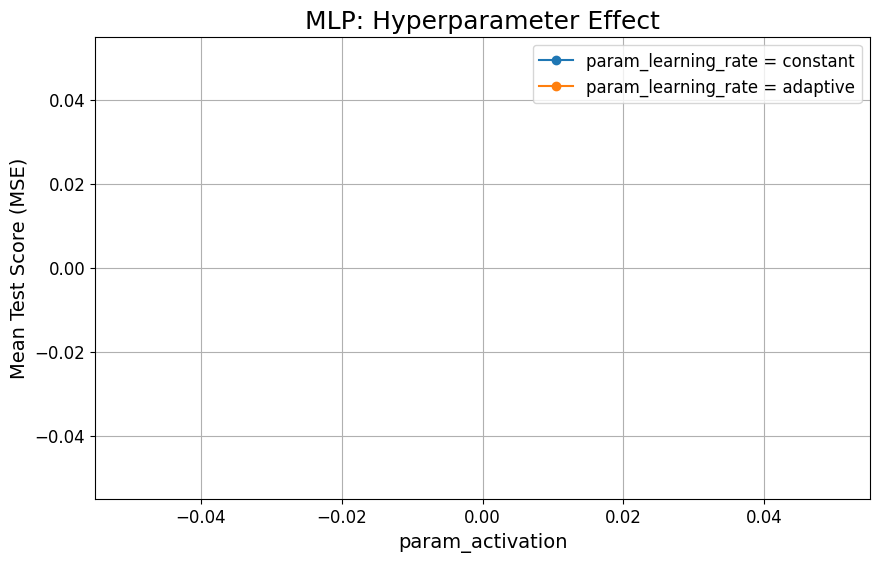

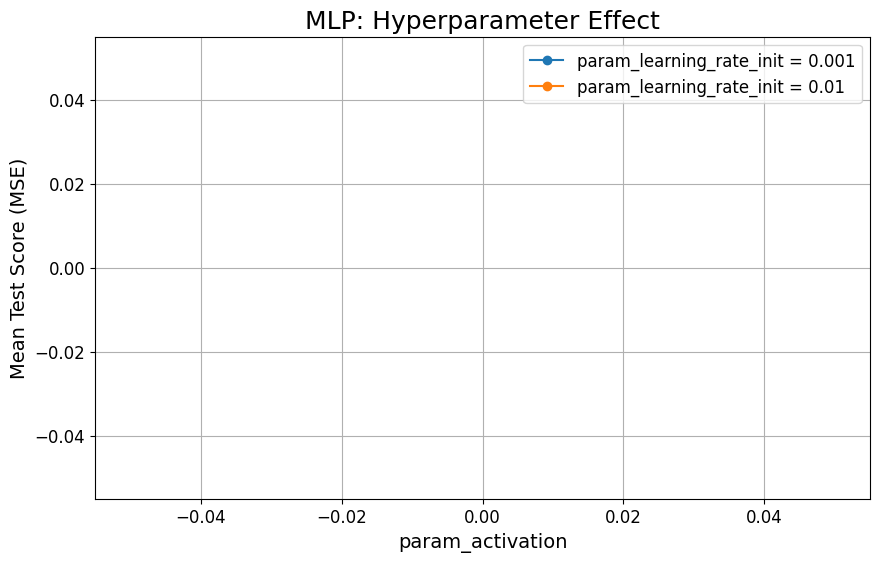

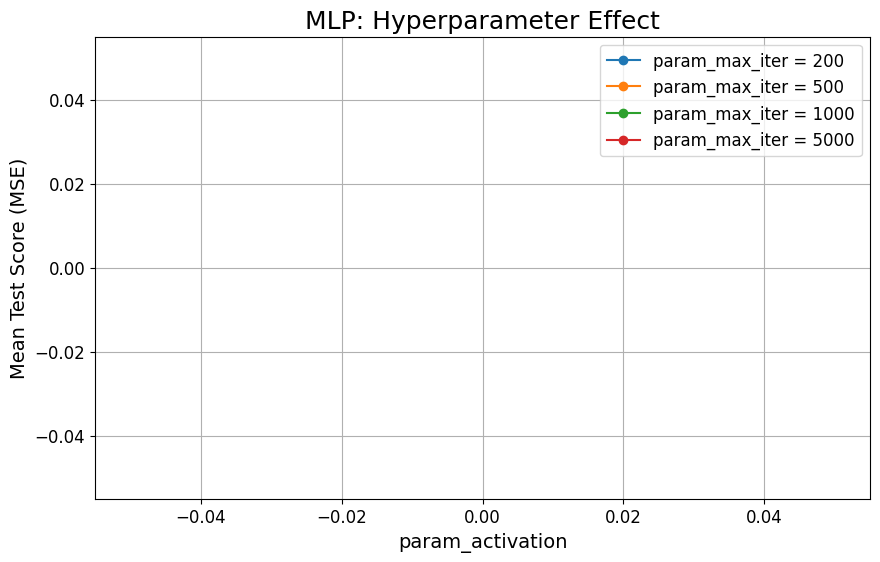

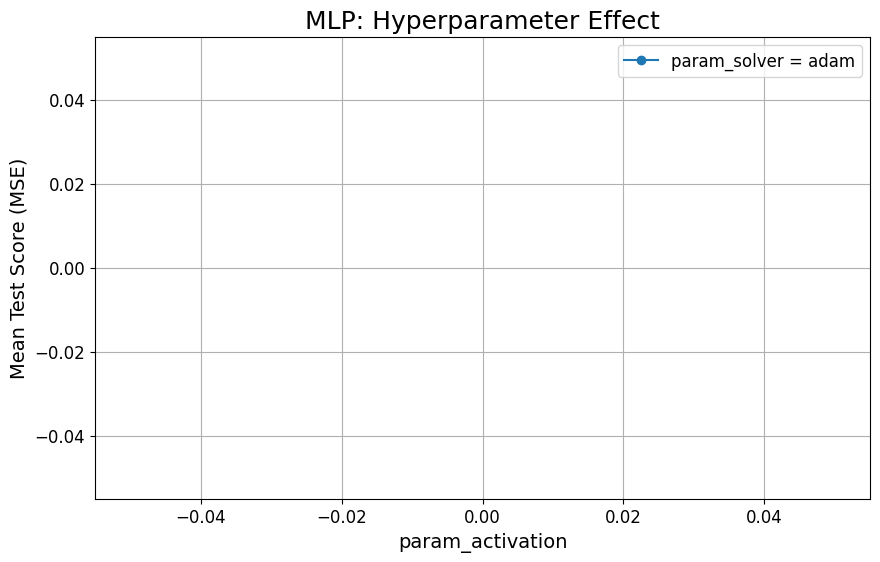

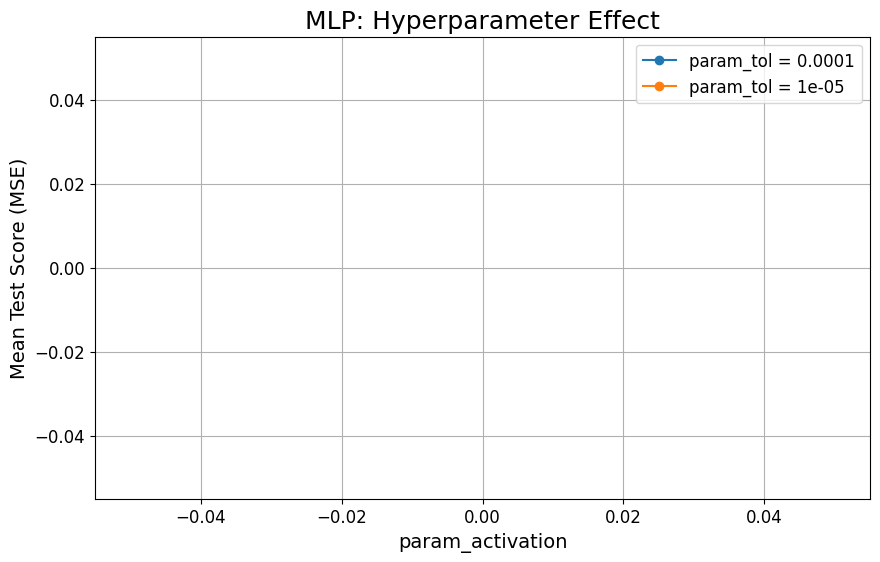

In [40]:
# Step 5: Train and tune model based on parameters
model_trainer_ground_delay.train_and_tune_single_model('BenchmarkModel', model_evaluator_ground_delay)  # Benchmark Model
model_trainer_ground_delay.train_and_tune_single_model('RandomForest', model_evaluator_ground_delay)    # Random Forest
model_trainer_ground_delay.train_and_tune_single_model('LinearRegression', model_evaluator_ground_delay)  # Linear Regression
model_trainer_ground_delay.train_and_tune_single_model('RidgeRegression', model_evaluator_ground_delay)   # Ridge Regression
model_trainer_ground_delay.train_and_tune_single_model('LassoRegression', model_evaluator_ground_delay)   # Lasso Regression
model_trainer_ground_delay.train_and_tune_single_model('ElasticNet', model_evaluator_ground_delay)        # ElasticNet
model_trainer_ground_delay.train_and_tune_single_model('PolynomialRegression', model_evaluator_ground_delay)  # Polynomial Regression
model_trainer_ground_delay.train_and_tune_single_model('SVR', model_evaluator_ground_delay)               # Support Vector Regression
model_trainer_ground_delay.train_and_tune_single_model('GradientBoosting', model_evaluator_ground_delay)  # Gradient Boosting
model_trainer_ground_delay.train_and_tune_single_model('HistGradientBoosting', model_evaluator_ground_delay)  # Hist Gradient Boosting
model_trainer_ground_delay.train_and_tune_single_model('MLP', model_evaluator_ground_delay)               # Multilayer Perceptron (MLP)

# Train and tune all models simultaneously (optional alternative to individual tuning)
# Uncomment the following line to execute batch training for all models at once:
# model_trainer_ground_delay.train_and_tune_models(model_evaluator_ground_delay)

In [41]:
# Step 6: Re-Instantiate ModelEvaluation with updated best_model list
model_evaluator_ground_delay = ModelEvaluation(data_prep_ground_delay, model_trainer_ground_delay.best_models)

### Evaluate and compare Models

In [45]:
# Step 7: Evaluate specific model
model_evaluator_ground_delay.evaluate_model('BenchmarkModel')
model_evaluator_ground_delay.evaluate_model('RandomForest')
model_evaluator_ground_delay.evaluate_model('LinearRegression')
model_evaluator_ground_delay.evaluate_model('RidgeRegression')
model_evaluator_ground_delay.evaluate_model('LassoRegression')
model_evaluator_ground_delay.evaluate_model('ElasticNet')
model_evaluator_ground_delay.evaluate_model('PolynomialRegression')
model_evaluator_ground_delay.evaluate_model('SVR')
model_evaluator_ground_delay.evaluate_model('GradientBoosting')
model_evaluator_ground_delay.evaluate_model('HistGradientBoosting')
model_evaluator_ground_delay.evaluate_model('MLP')

No scaling or normalization required for BenchmarkModel.
Completed preprocessing for BenchmarkModel.
Evaluating model: BenchmarkModel
Mean Absolute Error (MAE): 26.20
Root Mean Squared Error (RMSE): 35.24
R² Score (R²): -0.01
Residual Mean: -3.3338
Skewness: -0.2758
Kurtosis: 0.4592
No scaling or normalization required for RandomForest.
Completed preprocessing for RandomForest.
Evaluating model: RandomForest
Mean Absolute Error (MAE): 21.72
Root Mean Squared Error (RMSE): 27.64
R² Score (R²): 0.38
Residual Mean: 0.4318
Skewness: 0.4561
Kurtosis: 0.1952
Applied standard scaling to the data.
Completed preprocessing for LinearRegression.
Evaluating model: LinearRegression
Mean Absolute Error (MAE): 852400675748.61
Root Mean Squared Error (RMSE): 1067676026536.82
R² Score (R²): -926040299550892097536.00
Residual Mean: -20263877579.6849
Skewness: -0.7885
Kurtosis: -0.1057
Applied standard scaling to the data.
Completed preprocessing for RidgeRegression.
Evaluating model: RidgeRegression
Mea

In [ ]:
best = pd.DataFrame([model_trainer_ground_delay.best_models])
best

In [ ]:
data_without_processing = pd.DataFrame(model_trainer_ground_delay.results_table)
data_without_processing

In [46]:
# Summarize metrics for all evaluated models
summary = pd.DataFrame([
    {
        'Model': result['model_name'],
        'MAE': result['metrics']['MAE'],  # Mean Absolute Error
        'RMSE': result['metrics']['RMSE'],  # Root Mean Squared Error
        'R²': result['metrics']['R²'],  # R-Squared Score
        'Residual Mean': result['metrics']['residual_mean'],  # Mean of residuals
        'Residual Skewness': result['metrics']['skewness'],  # Skewness of residuals
        'Residual Kurtosis': result['metrics']['kurtosis']  # Kurtosis of residuals
    }
    for result in model_evaluator_ground_delay.evaluation_results  # Iterate through evaluation results
])

# Function to format large values dynamically
def format_large_values(val):
    """
    Formats large values (> 9999) in scientific notation and smaller values to 2 decimal places.
    """
    if isinstance(val, (int, float)):  # Apply only to numerical values
        if abs(val) > 9999:  # Threshold for large values
            return f"{val:.2e}"  # Scientific notation
        return round(val, 2)  # Round to two decimal places for smaller values
    return val  # Leave non-numeric values unchanged

# Apply the formatting function to the relevant columns
columns_to_format = ['MAE', 'RMSE', 'R²', 'Residual Mean', 'Residual Skewness', 'Residual Kurtosis']
for col in columns_to_format:
    summary[col] = summary[col].map(format_large_values)

# Ensure pandas output shows full table without wrapping
pd.set_option('display.width', None)  # Allow full table width display
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all rows (if large)

# Save the summary of evaluation metrics as a CSV file
summary.to_csv(f'4. model_evaluation_summary-ground_time_{input_variant}.csv', index=False)

# Display the summary in the console as a single block
print(summary.to_string(index=False))  # Use to_string() for full-width display


# Optional: Show all histograms stacked
# # Plot histograms of residuals for each evaluated model
# # Determine the number of models to plot
# num_models = len(model_evaluator_ground_delay.evaluation_results)

# # Create a grid of subplots with one column (stacked vertically)
# fig, axes = plt.subplots(num_models, 1, figsize=(8, 4 * num_models), sharex=True)

# # Ensure axes is iterable in case only one model is plotted
# if num_models == 1:
#     axes = [axes]

# # Loop through each model and plot its residuals histogram
# for i, result in enumerate(model_evaluator_ground_delay.evaluation_results):
#     model_name = result['model_name']  # Get the model name
#     residuals = result['residuals']  # Get the residuals of the model

#     # Plot residuals histogram on the corresponding subplot
#     sns.histplot(residuals, kde=True, color='blue', bins=30, ax=axes[i])
#     axes[i].set_title(f'Residuals Histogram for {model_name}', fontsize=16)  # Larger title
#     axes[i].set_ylabel('Frequency', fontsize=12)  # Larger y-axis label
#     axes[i].set_xlabel('Residuals', fontsize=12)  # Larger x-axis label
#     axes[i].tick_params(axis='both', labelsize=10)  # Increase tick label size

# # Adjust layout for better spacing between plots
# plt.tight_layout()
# plt.show()


               Model      MAE     RMSE        R² Residual Mean  Residual Skewness  Residual Kurtosis
                 SVR    20.51    26.91      0.41           8.8               0.26               0.48
    GradientBoosting    64.03   104.85     -7.93         53.36               1.20              -0.01
HistGradientBoosting    32.63     45.8      -0.7         26.51               0.75              -0.19
                 MLP    20.96    26.68      0.42          4.57               0.20              -0.05
      BenchmarkModel     26.2    35.24     -0.01         -3.33              -0.28               0.46
        RandomForest    21.72    27.64      0.38          0.43               0.46               0.20
    LinearRegression 8.52e+11 1.07e+12 -9.26e+20     -2.03e+10              -0.79              -0.11
     RidgeRegression     22.5    27.77      0.37         -0.37               0.11              -0.29
     LassoRegression    22.41    27.67      0.38         -0.39               0.10          

In [ ]:
# Helpful function to evaluate instances

# Best models from the trainer
model_trainer_ground_delay.best_models  # Dictionary of the best models after training

# Dictionary of models with their details
model_trainer_ground_delay.model_dict  # Contains model names and their trained instances

# Table of evaluation results for models
model_trainer_ground_delay.results_table  # Stores results of model evaluations, including metrics

# Results of the evaluation process
model_evaluator_ground_delay.evaluation_results  # Holds the metrics and evaluation outcomes for models

# Data used for training and testing the model
data_prep_ground_delay.df  # DataFrame containing the full dataset

# Training and test data splits for the target variable
data_prep_ground_delay.y_train  # Target variable for training
data_prep_ground_delay.y_test   # Target variable for testing

# Features used for training and testing the model
data_prep_ground_delay.X_train  # Feature set for training
data_prep_ground_delay.X_test   # Feature set for testing

### Visualize models

In [ ]:
# 2D
# Calculate the overall x-axis limits for residuals and predictions across all models
# all_residuals = [result['residuals'] for result in model_evaluator_ground_delay.evaluation_results]
# min_residual = min([residual.min() for residual in all_residuals])  # Minimum residual across models
# max_residual = max([residual.max() for residual in all_residuals])  # Maximum residual across models

# all_predictions = [result['predictions'] for result in model_evaluator_ground_delay.evaluation_results]
# min_prediction = min([pred.min() for pred in all_predictions])  # Minimum prediction across models
# max_prediction = max([pred.max() for pred in all_predictions])  # Maximum prediction across models


excluded_models = ['LinearRegression']  # Models to exclude
all_residuals = [
    result['residuals']
    for result in model_evaluator_ground_delay.evaluation_results
    if result['model_name'] not in excluded_models
]
all_predictions = [
    result['predictions']
    for result in model_evaluator_ground_delay.evaluation_results
    if result['model_name'] not in excluded_models
]

min_residual = min([residual.min() for residual in all_residuals])
max_residual = max([residual.max() for residual in all_residuals])
min_prediction = min([pred.min() for pred in all_predictions])
max_prediction = max([pred.max() for pred in all_predictions])


# Loop through each model's evaluation results
for result in model_evaluator_ground_delay.evaluation_results:
    model_name = result['model_name']  # Get model name

    # Fetch best model instance from the best_models dictionary
    best_model = model_evaluator_ground_delay.best_models.get(model_name, None)
    if best_model:
        if isinstance(best_model, DummyRegressor):  # Handle DummyRegressor specifically
            best_params_str = "strategy=mean"
        elif hasattr(best_model, 'get_params'):  # Check if the model supports get_params()
            # Only include relevant hyperparameters for better readability
            relevant_params = ['max_depth', 'n_estimators', 'alpha', 'l1_ratio', 'degree']  # Adjust as needed
            best_params = best_model.get_params()
            filtered_params = {k: v for k, v in best_params.items() if k in relevant_params}
            best_params_str = ', '.join([f"{key}={value}" for key, value in filtered_params.items()])
        else:
            best_params_str = "None"
    else:
        best_params_str = "None"

    residuals = result['residuals']  # Residuals for the model
    y_pred = result['predictions']  # Predicted values for the model

    # Access the actual test labels
    y_test = model_evaluator_ground_delay.data_preparation.y_test

    # Ensure y_test and y_pred are NumPy arrays for operations
    y_test = np.asarray(y_test)
    y_pred = np.asarray(y_pred)

    # Calculate residual metrics
    residual_mean = residuals.mean()  # Mean of residuals
    residual_skewness = skew(residuals)  # Skewness of residuals
    residual_kurtosis = stats.kurtosis(residuals)  # Kurtosis of residuals

    # Calculate error metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Create combined plots: Residuals Histogram and Residuals vs Predicted
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))  # Two subplots: 1 row, 2 columns

    # Residuals Histogram
    sns.histplot(residuals, kde=True, color='purple', bins=30, ax=axes[0])
    axes[0].set_title(f'Residuals Histogram for {model_name}', fontsize=14)
    axes[0].set_xlabel('Residuals', fontsize=12)
    axes[0].set_ylabel('Frequency', fontsize=12)
    axes[0].set_xlim(min_residual, max_residual)

    # Add annotations for residual metrics
    axes[0].text(0.05, 0.85, f'Residual Mean: {residual_mean:.4f}', transform=axes[0].transAxes, fontsize=10, color='black')
    axes[0].text(0.05, 0.80, f'Skewness: {residual_skewness:.4f}', transform=axes[0].transAxes, fontsize=10, color='black')
    axes[0].text(0.05, 0.75, f'Kurtosis: {residual_kurtosis:.4f}', transform=axes[0].transAxes, fontsize=10, color='black')

    # Residuals vs Predicted Plot
    sns.scatterplot(x=y_pred, y=residuals, ax=axes[1])
    axes[1].axhline(0, color='red', linestyle='--')  # Add horizontal line at residual = 0
    axes[1].set_title(f'Residuals vs Predicted for {model_name}', fontsize=14)
    axes[1].set_xlabel('Predicted Ground Delay Time', fontsize=12)
    axes[1].set_ylabel('Residuals', fontsize=12)
    axes[1].set_xlim(min_prediction, max_prediction)
    axes[1].set_ylim(min_residual, max_residual)
    axes[1].grid(True)

    # Add annotations for error metrics
    axes[1].text(0.05, 0.95, f'MAE: {mae:.2f}', transform=axes[1].transAxes, fontsize=10, color='black')
    axes[1].text(0.05, 0.90, f'RMSE: {rmse:.2f}', transform=axes[1].transAxes, fontsize=10, color='black')
    axes[1].text(0.05, 0.85, f'R²: {r2:.4f}', transform=axes[1].transAxes, fontsize=10, color='black')

    # Add model and hyperparameter details below the plots
    fig.text(0.5, 0.01, f'Model: {model_name} | Best Params: {best_params_str}', ha='center', fontsize=12, color='blue')

    # Adjust layout and display the plots
    plt.tight_layout(rect=[0, 0.02, 1, 1])  # Leave space for additional text
    plt.show()

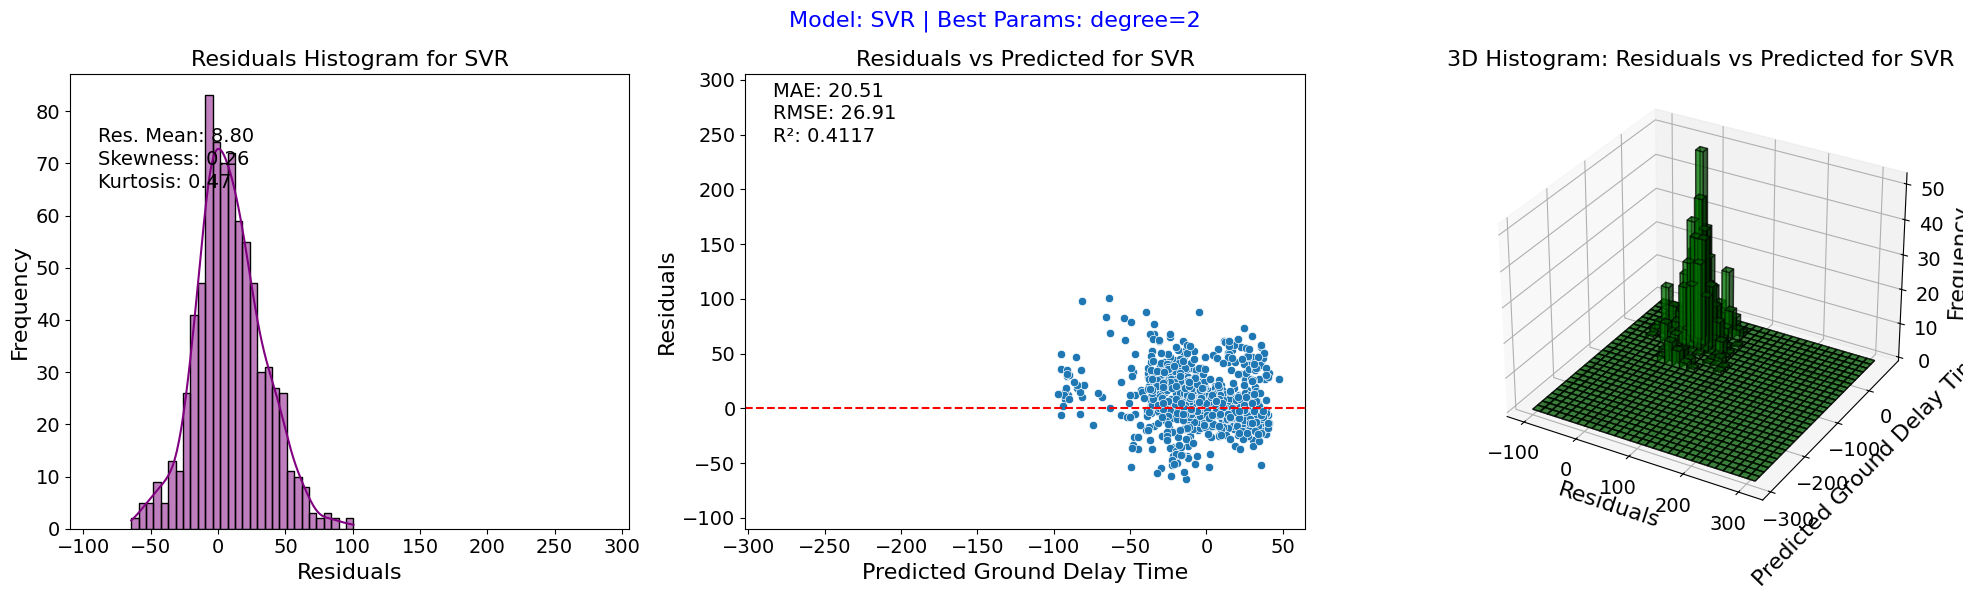

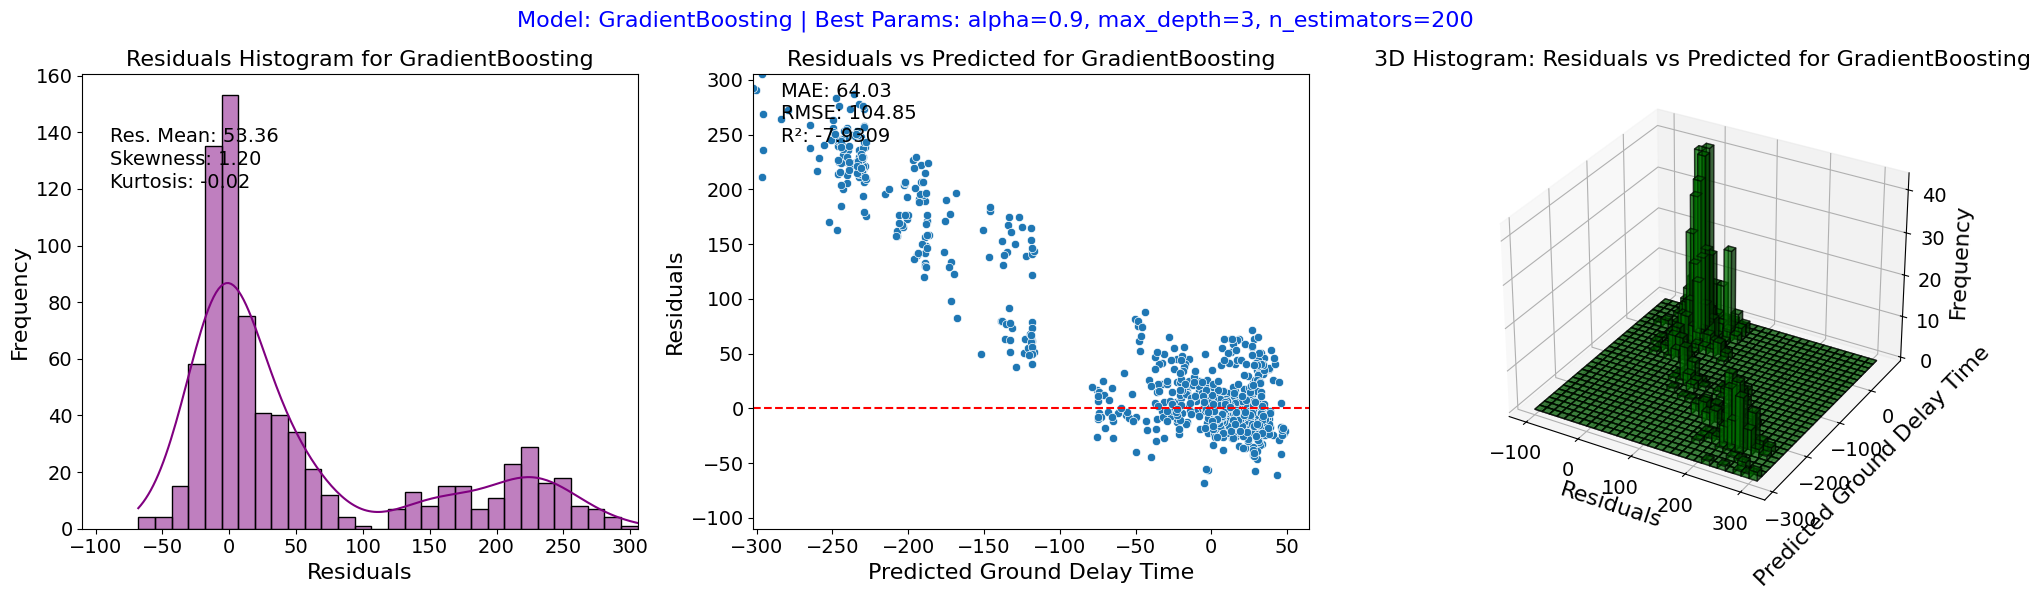

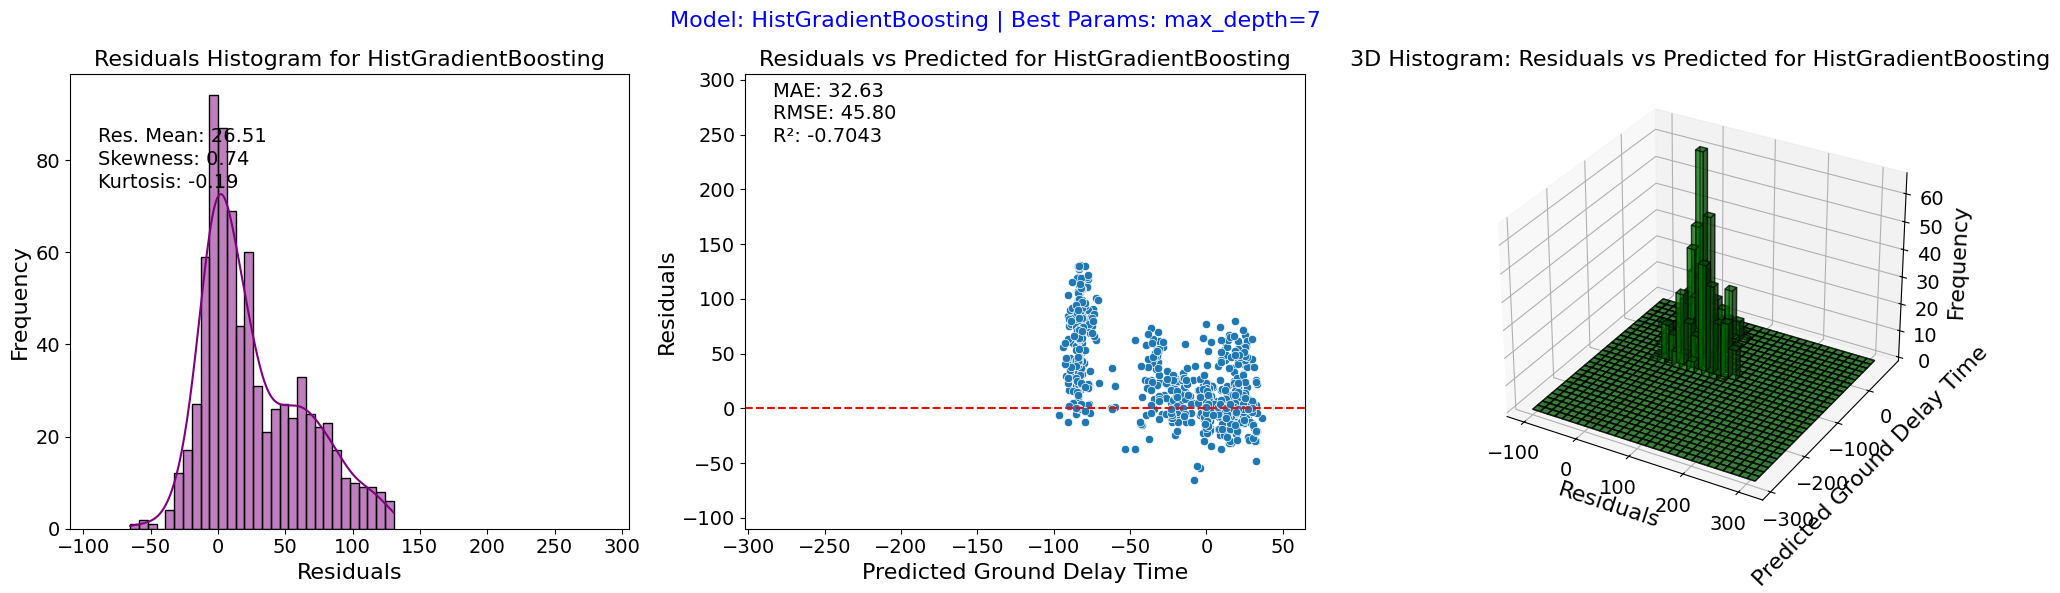

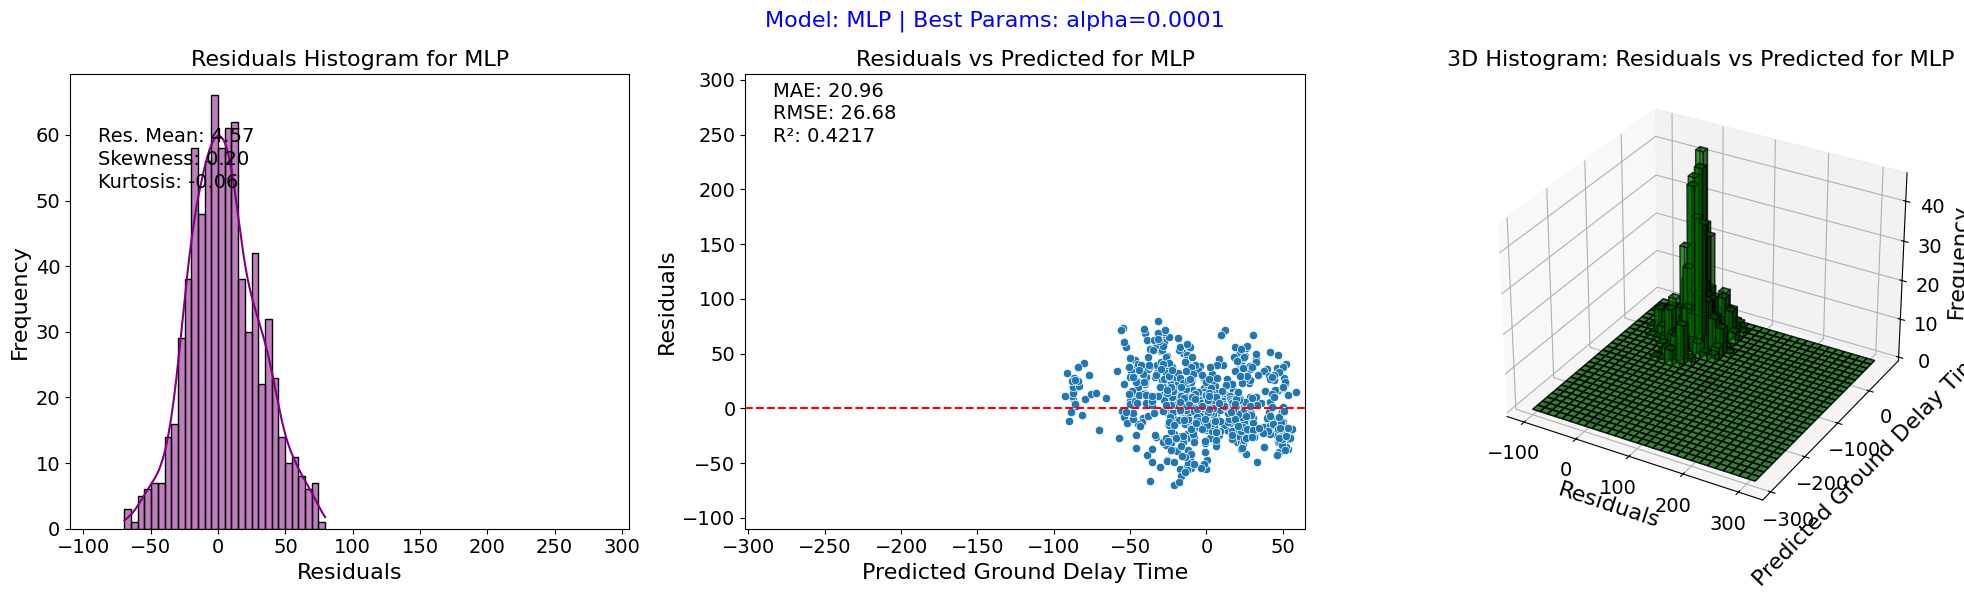

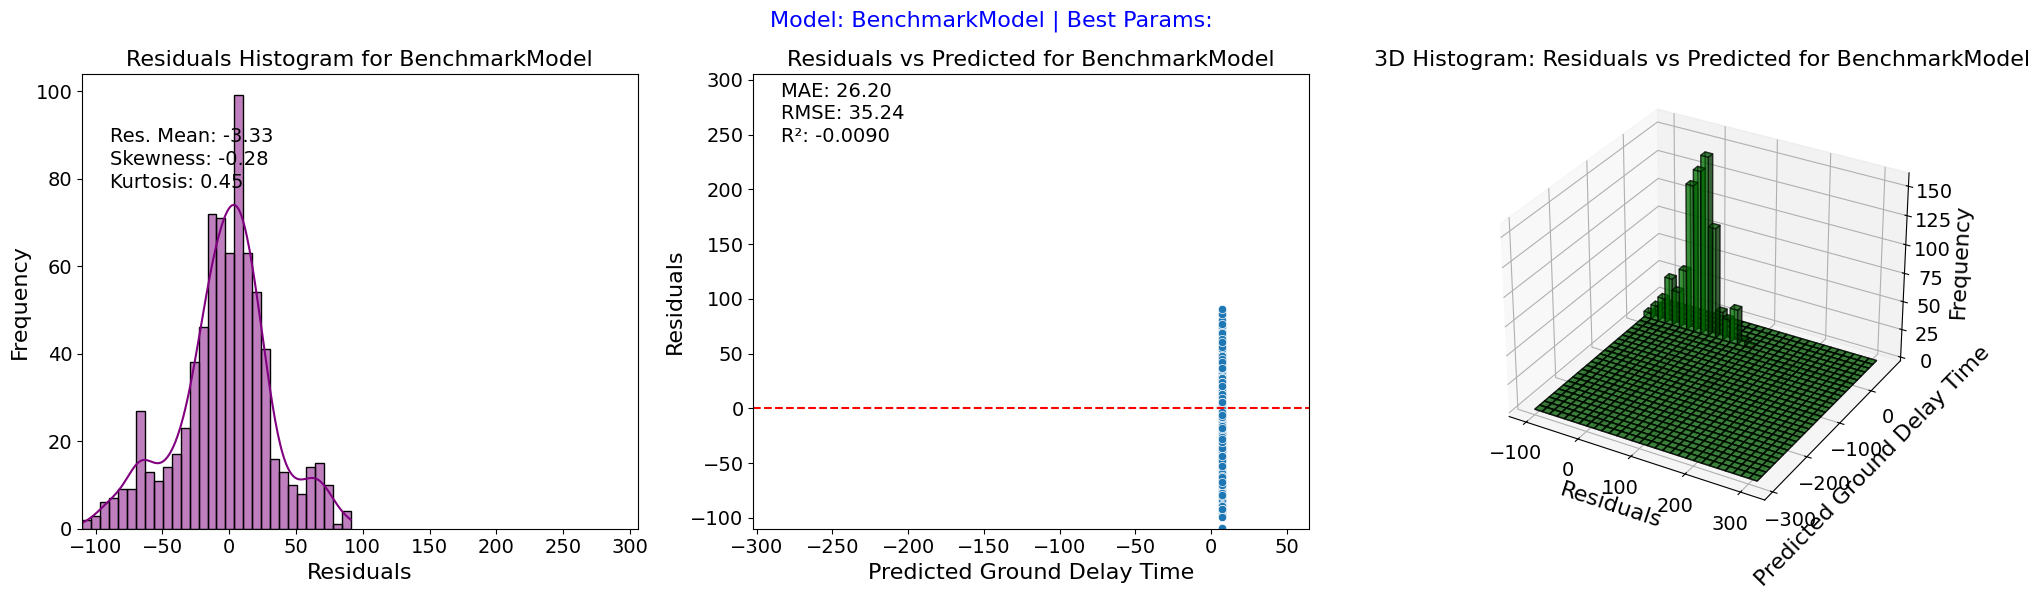

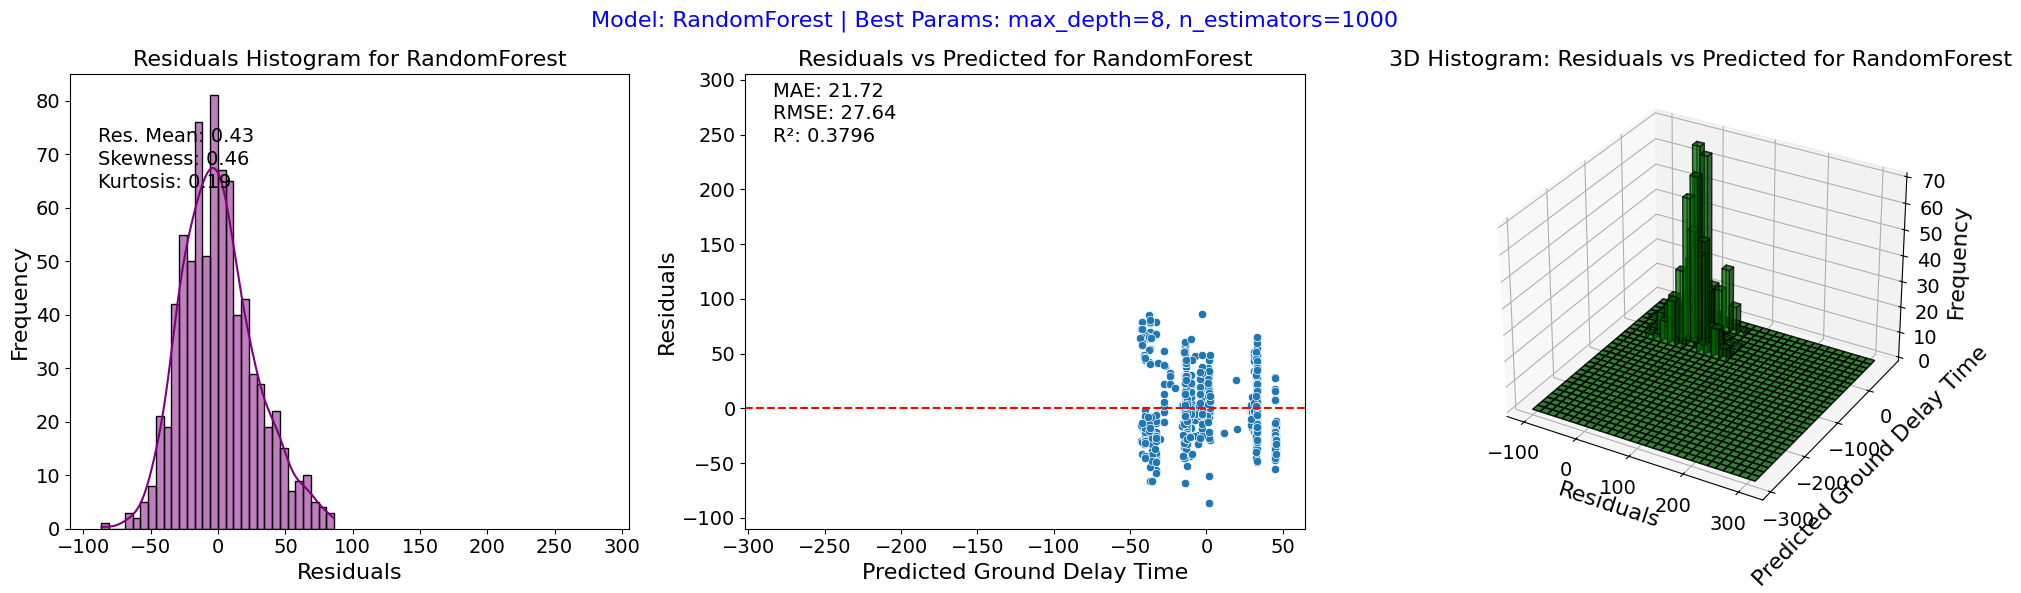

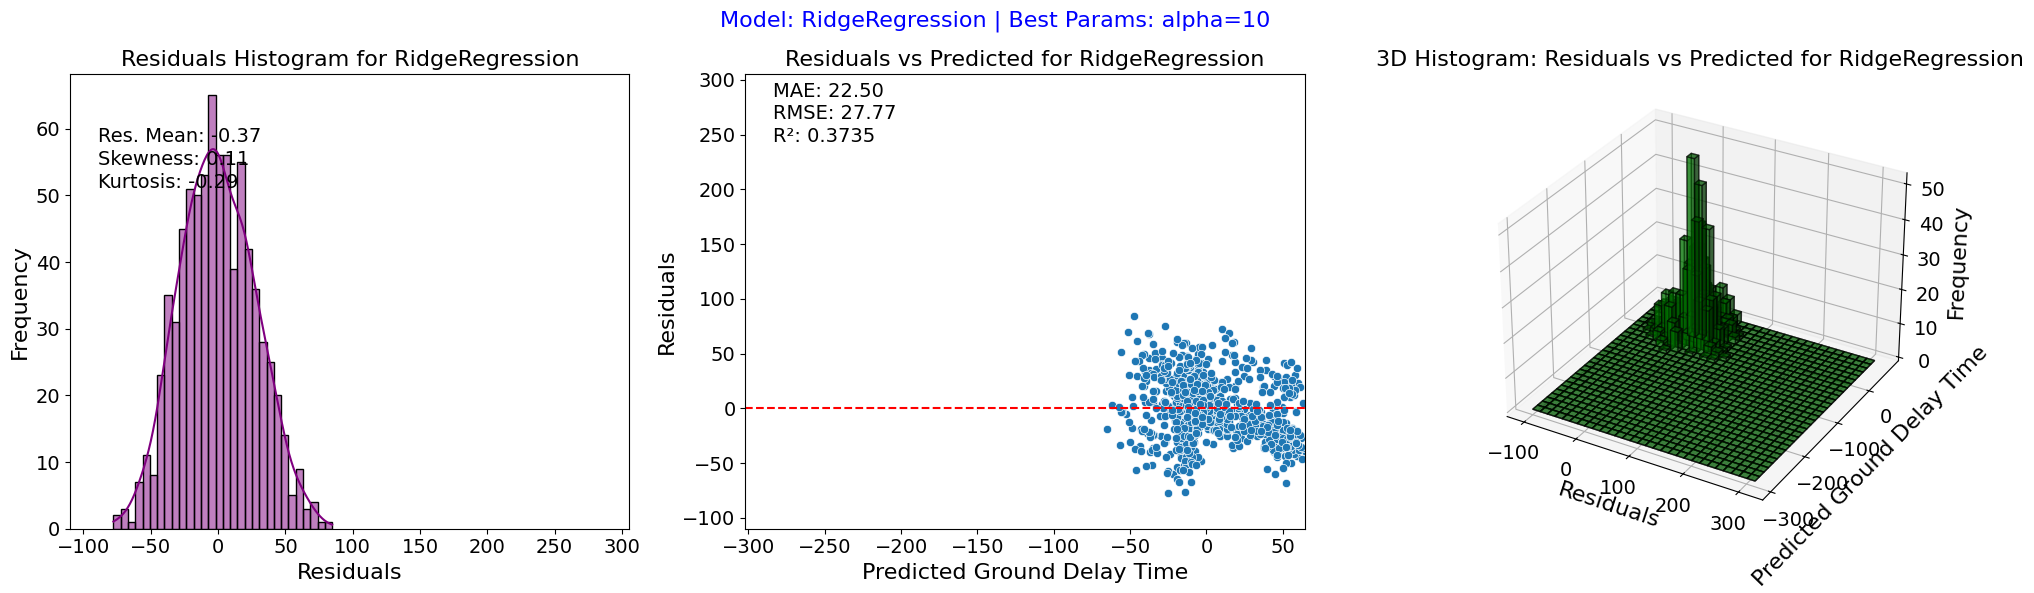

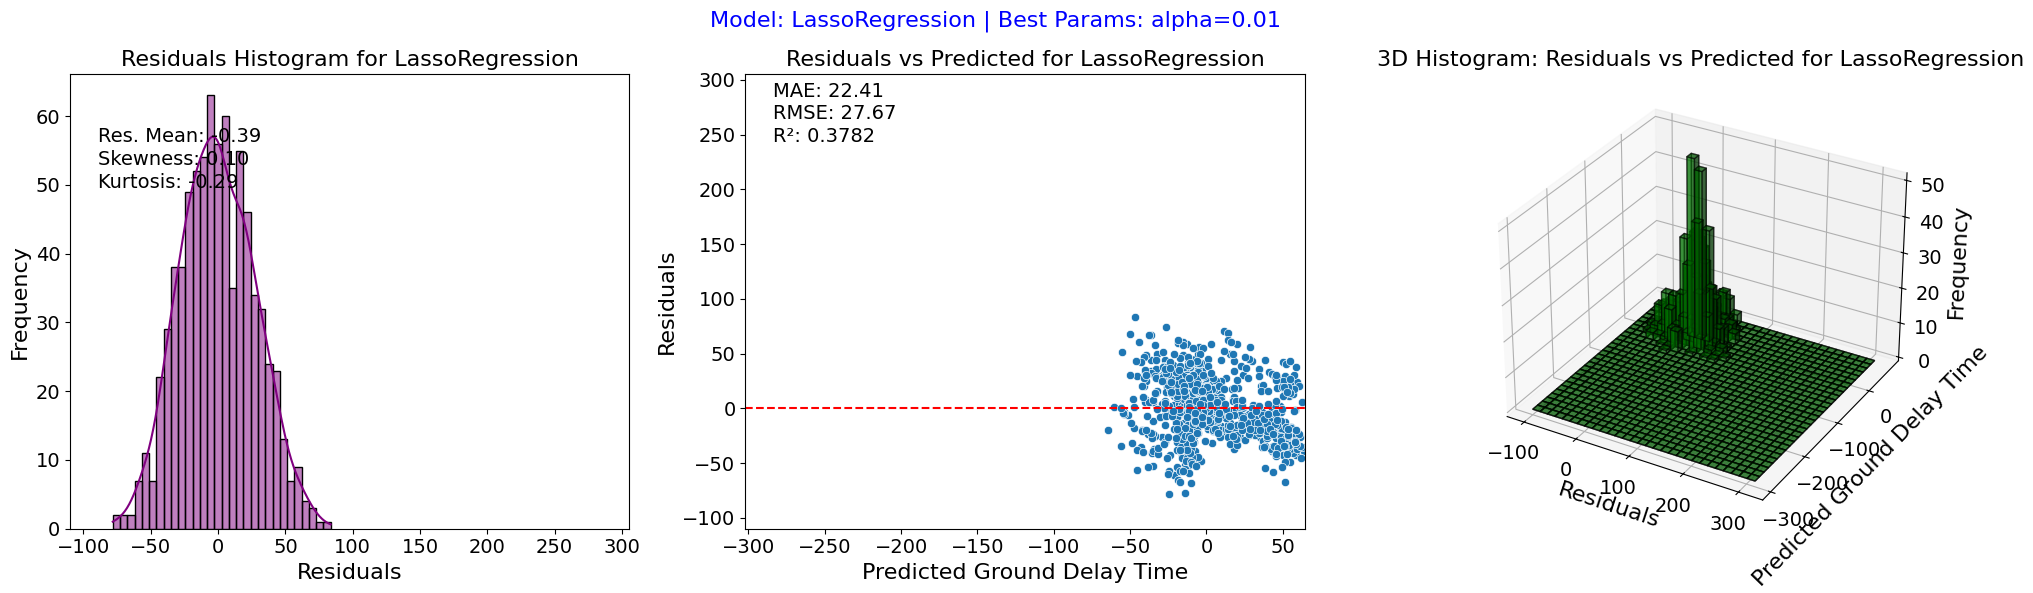

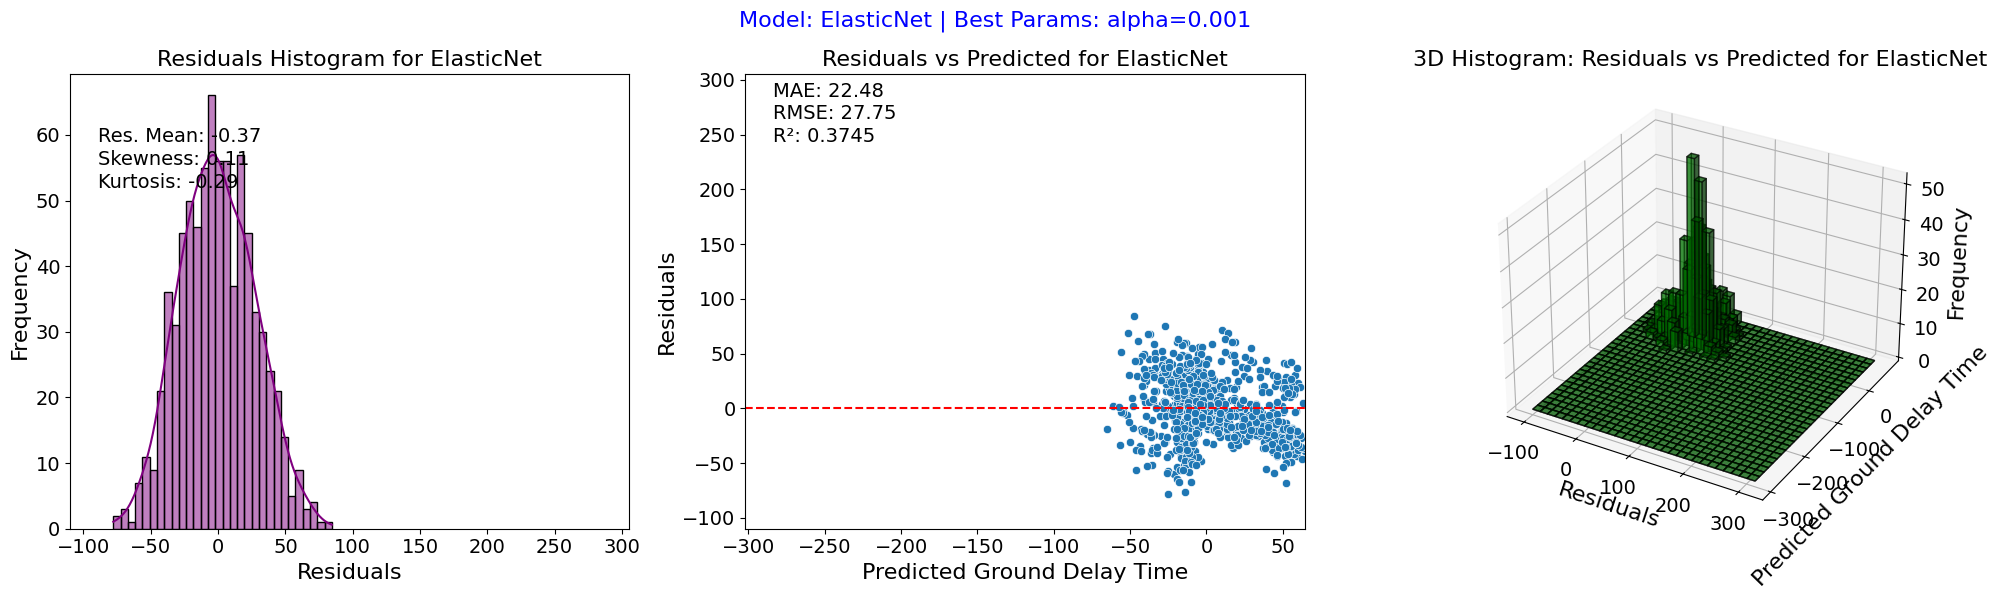

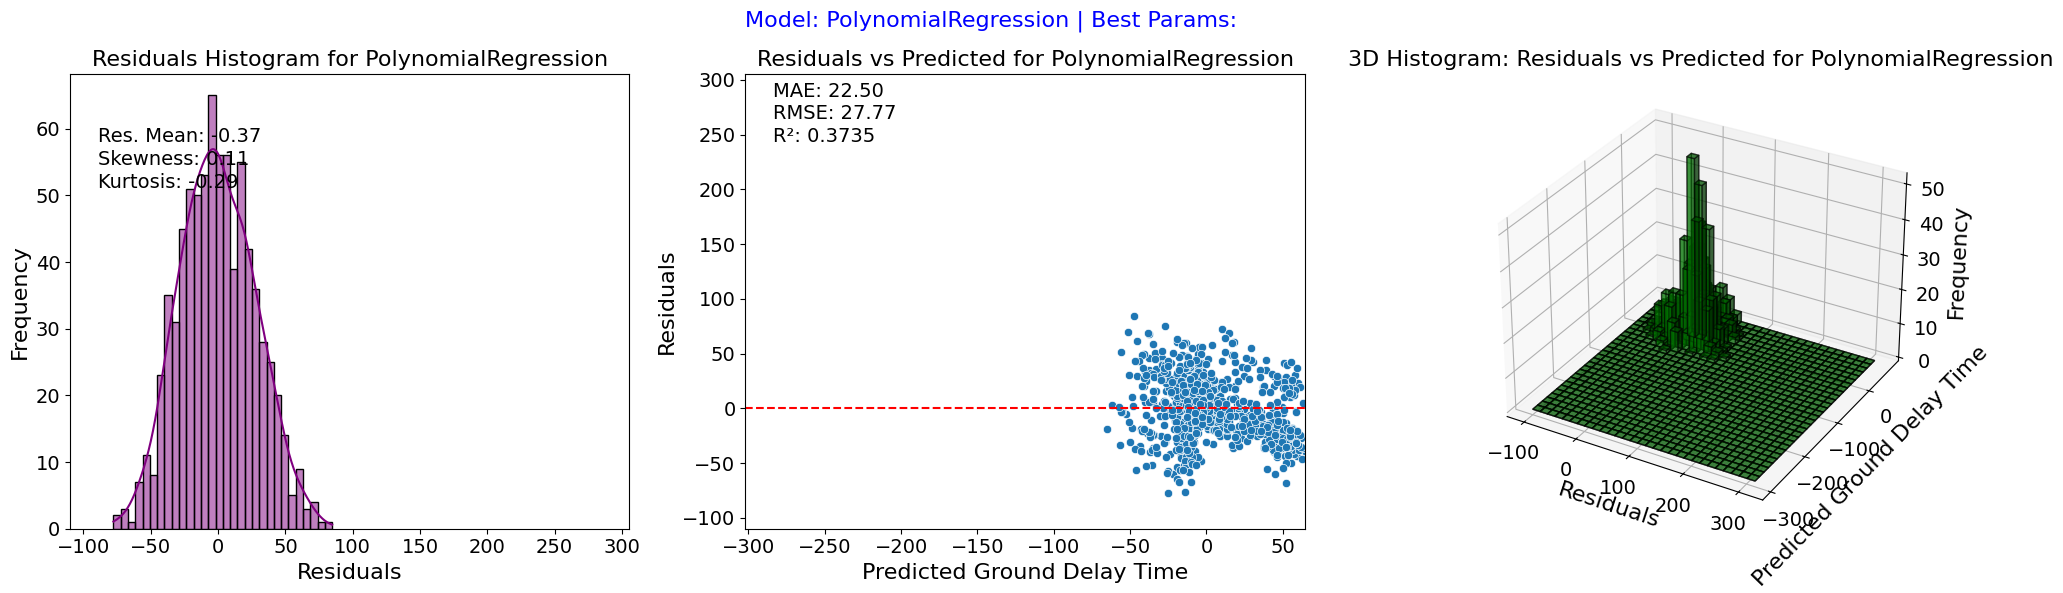

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Specify models to exclude from scaling calculations
excluded_models = ['LinearRegression']

# Calculate overall axis limits across all models, excluding specified models
all_residuals = [
    result['residuals']
    for result in model_evaluator_ground_delay.evaluation_results
    if result['model_name'] not in excluded_models
]
all_y_pred = [
    result['predictions']
    for result in model_evaluator_ground_delay.evaluation_results
    if result['model_name'] not in excluded_models
]

# Compute global axis limits
min_residual = min([residual.min() for residual in all_residuals])
max_residual = max([residual.max() for residual in all_residuals])
min_pred = min([y_pred.min() for y_pred in all_y_pred])
max_pred = max([y_pred.max() for y_pred in all_y_pred])

# Adjust ranges to avoid zero range issues
if min_residual == max_residual:
    min_residual -= 0.1
    max_residual += 0.1

if min_pred == max_pred:
    min_pred -= 0.1
    max_pred += 0.1

# Font sizes for various plot elements
title_fontsize = 16
axis_label_fontsize = 16
legend_fontsize = 14
annotation_fontsize = 14
tick_label_fontsize = 14

# Loop through each model's results to generate the plots
for result in model_evaluator_ground_delay.evaluation_results:
    model_name = result['model_name']

    # Skip models in excluded_models
    if model_name in excluded_models:
        continue

    residuals = result['residuals']
    y_pred = result['predictions']

    # Fetch best parameters from best_models
    best_model = model_evaluator_ground_delay.best_models.get(model_name)
    if best_model:
        # Try to extract hyperparameters depending on the model type
        if hasattr(best_model, 'get_params'):
            best_params = best_model.get_params()
            best_params_str = ', '.join([f"{key}={value}" for key, value in best_params.items() if key in ['max_depth', 'n_estimators', 'alpha', 'degree']])
        else:
            best_params_str = "No hyperparameters available"
    else:
        best_params_str = "None"

    # Access y_test
    y_test = np.asarray(model_evaluator_ground_delay.data_preparation.y_test)

    # Calculate metrics
    residual_mean = residuals.mean()
    residual_skewness = skew(residuals)
    residual_kurtosis = kurtosis(residuals)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Create a figure with three subplots
    fig = plt.figure(figsize=(20, 6))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1])

    # Residuals Histogram
    ax0 = fig.add_subplot(gs[0])
    sns.histplot(residuals, kde=True, color='purple', bins=30, ax=ax0)
    ax0.set_title(f'Residuals Histogram for {model_name}', fontsize=title_fontsize)
    ax0.set_xlabel('Residuals', fontsize=axis_label_fontsize)
    ax0.set_ylabel('Frequency', fontsize=axis_label_fontsize)
    ax0.set_xlim(min_residual, max_residual)
    ax0.tick_params(axis='both', labelsize=tick_label_fontsize)
    ax0.text(0.05, 0.85, f'Res. Mean: {residual_mean:.2f}', transform=ax0.transAxes, fontsize=annotation_fontsize)
    ax0.text(0.05, 0.80, f'Skewness: {residual_skewness:.2f}', transform=ax0.transAxes, fontsize=annotation_fontsize)
    ax0.text(0.05, 0.75, f'Kurtosis: {residual_kurtosis:.2f}', transform=ax0.transAxes, fontsize=annotation_fontsize)

    # Residuals vs Predicted Plot
    ax1 = fig.add_subplot(gs[1])
    sns.scatterplot(x=y_pred, y=residuals, ax=ax1)
    ax1.axhline(0, color='red', linestyle='--')
    ax1.set_title(f'Residuals vs Predicted for {model_name}', fontsize=title_fontsize)
    ax1.set_xlabel('Predicted Ground Delay Time', fontsize=axis_label_fontsize)
    ax1.set_ylabel('Residuals', fontsize=axis_label_fontsize)
    ax1.set_xlim(min_pred, max_pred)
    ax1.set_ylim(min_residual, max_residual)
    ax1.tick_params(axis='both', labelsize=tick_label_fontsize)
    ax1.text(0.05, 0.95, f'MAE: {mae:.2f}', transform=ax1.transAxes, fontsize=annotation_fontsize)
    ax1.text(0.05, 0.90, f'RMSE: {rmse:.2f}', transform=ax1.transAxes, fontsize=annotation_fontsize)
    ax1.text(0.05, 0.85, f'R²: {r2:.4f}', transform=ax1.transAxes, fontsize=annotation_fontsize)

    # 3D Histogram of Residuals vs Predicted
    ax2 = fig.add_subplot(gs[2], projection='3d')
    x_bins = np.linspace(min_residual, max_residual, 30)
    y_bins = np.linspace(min_pred, max_pred, 30)
    hist, x_edges, y_edges = np.histogram2d(residuals, y_pred, bins=[x_bins, y_bins])

    x_pos, y_pos = np.meshgrid(
        x_edges[:-1] + 0.5 * np.diff(x_edges),
        y_edges[:-1] + 0.5 * np.diff(y_edges),
        indexing="ij"
    )
    x_pos = x_pos.ravel()
    y_pos = y_pos.ravel()
    z_pos = np.zeros_like(x_pos)
    dx = np.diff(x_edges)[0]
    dy = np.diff(y_edges)[0]
    dz = hist.ravel()

    ax2.bar3d(x_pos, y_pos, z_pos, dx, dy, dz, alpha=0.5, color='green', edgecolor='black')
    ax2.set_title(f'3D Histogram: Residuals vs Predicted for {model_name}', fontsize=title_fontsize)
    ax2.set_xlabel('Residuals', fontsize=axis_label_fontsize)
    ax2.set_ylabel('Predicted Ground Delay Time', fontsize=axis_label_fontsize)
    ax2.set_zlabel('Frequency', fontsize=axis_label_fontsize)
    ax2.tick_params(axis='both', labelsize=tick_label_fontsize)

    # Add model name and best parameters as title
    fig.suptitle(f'Model: {model_name} | Best Params: {best_params_str}', fontsize=title_fontsize, color='blue')

    plt.tight_layout()
    plt.show()


### Instanzen abspeichern

In [48]:
# Save the model_trainer instance
with open(f'model_trainer_ground_delay_{input_variant}.pkl', 'wb') as file:
    pickle.dump(model_trainer_ground_delay, file)
print(f"Model trainer instance saved successfully as model_trainer_ground_delay_{input_variant}.pkl")

# Save the model_evaluator instance
with open(f'model_evaluator_ground_delay_{input_variant}.pkl', 'wb') as file:
    pickle.dump(model_evaluator_ground_delay, file)
print(f"Model evaluator instance saved successfully as model_evaluator_ground_delay_{input_variant}.pkl")

# Save the data_prep instance
with open(f'data_prep_ground_delay_{input_variant}.pkl', 'wb') as file:
    pickle.dump(data_prep_ground_delay, file)
print(f"Data preparation instance saved successfully as data_prep_ground_delay_{input_variant}.pkl")

Model trainer instance saved successfully as model_trainer_ground_delay_long.pkl
Model evaluator instance saved successfully as model_evaluator_ground_delay_long.pkl
Data preparation instance saved successfully as data_prep_ground_delay_long.pkl


### Instanzen Laden

In [ ]:
# Load the saved model_trainer instance
with open(f'model_trainer_ground_delay_{input_variant}.pkl', 'rb') as file:
    globals()[f'model_trainer_ground_delay_{input_variant}_reloaded'] = pickle.load(file)
print(f"Model trainer instance for {input_variant} loaded successfully.")
print(globals()[f'model_trainer_ground_delay_{input_variant}_reloaded'].model_dict)  # Displays the stored model configurations

# Load the saved model_evaluator instance
with open(f'model_evaluator_ground_delay_{input_variant}.pkl', 'rb') as file:
    globals()[f'model_evaluator_ground_delay_{input_variant}_reloaded'] = pickle.load(file)
print(f"Model evaluator instance for {input_variant} loaded successfully.")
print(globals()[f'model_evaluator_ground_delay_{input_variant}_reloaded'].evaluation_results)  # Displays the stored model configurations

# Load the saved data_prep instance
with open(f'data_prep_ground_delay_{input_variant}.pkl', 'rb') as file:
    globals()[f'data_prep_ground_delay_{input_variant}_reloaded'] = pickle.load(file)
print(f"Data preparation instance for {input_variant} loaded successfully.")
print(globals()[f'data_prep_ground_delay_{input_variant}_reloaded'].target_column)  # Displays the stored model configurations